<a href="https://colab.research.google.com/github/victormurcia/CTS_Test/blob/main/CTS_Reworked_Cohort_Full_Routine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn2
import urllib.request
import zipfile,shutil, os,datetime,re,math,random,requests,datetime,glob
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#For visualization
import plotly.express as px
from ipywidgets import interact, IntSlider
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import spacy
#Spacy pipeline for biomedical data. Has a larger vocabulary and 50k word vectors
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz --quiet

#For usage of NER model
!pip install -q transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
#Define NER stuff
tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

#For abstactive summarization
import torch
#!pip install sentencepiece
#!pip install openai
#import openai
#from transformers import T5ForConditionalGeneration, T5Tokenizer

!pip install -q python-Levenshtein
!pip install -q fuzzywuzzy
from fuzzywuzzy import fuzz, process

!pip install fuzzyset
import fuzzyset

#Enable data to be extracted and downloaded from my Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

pd.set_option('display.max_columns', 17)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 1.9 MB/s eta 0:00:00
Mounted at /content/drive


# Functions

In [2]:
def process_patients_df(df, match_value, exclude_columns, sample_frac=0.1):
    """
    Process the patients' DataFrame by sampling, modifying boolean columns, and adding a 'Match' column.

    Parameters:
        df (DataFrame): The DataFrame to process.
        match_value (int): The value to assign in the 'Match' column.
        sample_frac (float, optional): Fraction of the DataFrame to sample. Default is 0.1.

    Returns:
        DataFrame: Processed DataFrame with modified values and the 'Match' column.
    """
    # Sample from the cohort dataframe
    sampled_df = df.sample(frac=sample_frac, random_state=42)

    bool_columns_to_check = [col for col in exclude_columns if col in sampled_df.columns]
    other_bool_columns = sampled_df.select_dtypes(include='bool').columns.difference(bool_columns_to_check)

    if match_value == 1:
        sampled_df.loc[:, bool_columns_to_check] = True
        sampled_df.loc[:, other_bool_columns] = False
    elif match_value == -1:
        sampled_df.loc[:, bool_columns_to_check] = False
        sampled_df.loc[:, other_bool_columns] = True
    sampled_df['Match'] = match_value

    return sampled_df

def create_labeled_cohort_df(cohort_df,exclude_columns):
    """
    Create a labeled cohort DataFrame by processing and combining different patient groups.

    Parameters:
        cohort_df (DataFrame): The original cohort DataFrame.

    Returns:
        DataFrame: Labeled cohort DataFrame with 'Match' column and processed data.
    """
    # Assuming 'cohort' is your original dataframe
    perfect_patients_df = process_patients_df(cohort_df, 1, exclude_columns)
    worst_patients_df   = process_patients_df(cohort_df, -1,exclude_columns)

    # Reset indices of worst_patients_df and perfect_patients_df
    worst_patients_df = worst_patients_df.reset_index(drop=True)
    perfect_patients_df = perfect_patients_df.reset_index(drop=True)

    # Get the row indices from df1 that you want to remove from df2
    row_indices_to_remove_worst = cohort_df.index.intersection(worst_patients_df.index)
    # Remove rows from df2 based on the row indices obtained
    mixed_patients_df = cohort_df.drop(row_indices_to_remove_worst)

    # Reset indices of mixed_patients_df for alignment
    mixed_patients_df = mixed_patients_df.reset_index(drop=True)

    # Remove rows from df1 based on the index values present in df2
    row_indices_to_remove_perfect = cohort_df.index.intersection(perfect_patients_df.index)
    mixed_patients_df = mixed_patients_df.drop(row_indices_to_remove_perfect)

    # Add a 'Match' column to mixed_patients_df
    mixed_patients_df['Match'] = 0

    # Concatenate the DataFrames to create the 'cohort' DataFrame
    cohort_df = pd.concat([perfect_patients_df, mixed_patients_df, worst_patients_df]).reset_index(drop=True)

    return cohort_df

def generate_patient_profile(cohort_df, patient_id):
    """
    Generate a patient profile based on the specified patient's index.

    Parameters:
        cohort_df (DataFrame): The cohort DataFrame containing patient information.
        patient_id (int): The index of the patient for which to generate the profile.

    Returns:
        dict: A dictionary representing the patient's profile.
    """
    if patient_id < 0 or patient_id >= len(cohort_df):
        raise IndexError("Invalid patient_id")

    # Get the row as a pandas Series
    patient_info = cohort_df.iloc[patient_id]

    # Convert the row to a dictionary
    patient_profile = patient_info.to_dict()

    return patient_profile

def process_eligibility_criteria(criteria_text):
    """
    Process the eligibility criteria text and create DataFrames for inclusion and exclusion criteria.

    Parameters:
        criteria_text (str): The eligibility criteria text.

    Returns:
        DataFrame: DataFrame containing inclusion criteria.
        DataFrame: DataFrame containing exclusion criteria.
    """
    # Split the criteria text into inclusion and exclusion criteria
    criteria_split = re.split(r'Exclusion Criteria:|Exclusion Criteria', criteria_text)
    inclusion_criteria = criteria_split[0].strip().replace("Inclusion Criteria:", "").replace("Inclusion Criteria", "")
    exclusion_criteria = criteria_split[1].strip().replace("Exclusion Criteria:", "").replace("Exclusion Criteria", "") if len(criteria_split) > 1 else ""

    # Remove "Exclusion Criteria" label
    exclusion_criteria = re.sub(r'^\s*Exclusion Criteria\s*', '', exclusion_criteria)

    # Create DataFrames for inclusion and exclusion criteria
    inclusion_list = [c.strip() for c in inclusion_criteria.split('\n') if c.strip()]
    exclusion_list = [c.strip() for c in exclusion_criteria.split('\n') if c.strip()]

    exclusion_df = pd.DataFrame({'Criteria': exclusion_list})
    inclusion_df = pd.DataFrame({'Criteria': inclusion_list})

    # Remove everything inside parentheses and hyphens
    inclusion_df['Criteria'] = inclusion_df['Criteria'].replace(r'\(.*?\)', '', regex=True).replace(r'-', '', regex=True)
    exclusion_df['Criteria'] = exclusion_df['Criteria'].replace(r'\(.*?\)', '', regex=True).replace(r'-', '', regex=True)

    return inclusion_df, exclusion_df

def run_ner_on_criteria(criteria_df, model, tokenizer,criteria,entity_types,score_threshold=0.2,keys_to_remove=[]):
    # Define NER pipeline
    pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="average") #Might be worth rtying a different aggregation strategy ("simple" "first" "max" "average")
    # Define a function that takes a piece of text and returns model predictions
    def get_entities(text):
        result = pipe(text)
        return result

    # Apply NER to the 'Criteria' column
    criteria_df['entities'] = criteria_df['Criteria'].apply(get_entities)

    # Explode the 'entities' column into separate rows
    criteria_df = criteria_df.explode('entities')

    # Create new columns
    criteria_df['entity_group'] = criteria_df['entities'].apply(lambda x: x['entity_group'] if pd.notnull(x) else None)
    criteria_df['score'] = criteria_df['entities'].apply(lambda x: x['score'] if pd.notnull(x) else None)
    criteria_df['word'] = criteria_df['entities'].apply(lambda x: x['word'] if pd.notnull(x) else None)
    criteria_df = criteria_df.reset_index(drop=True)

    # Filter and clean up criteria dataFrame
    #criteria_df = criteria_df[(criteria_df['entity_group'].isin(entity_types)) & (criteria_df['score'] > score_threshold)].reset_index() #If accuracy score is below threshold remove that entity
    criteria_df['combined_word'] = criteria_df['word'].apply(lambda x: x.replace('##', '').replace("'", '').replace("  ", '') if x is not None else '')

    # Create a new DataFrame to store the combined rows
    combined_criteria_df = pd.DataFrame(columns=criteria_df.columns)

    # Iterate over the rows to combine words that were overly tokenized
    i = 0
    while i < len(criteria_df):
        row = criteria_df.iloc[i].copy()
        # If the next word(s) starts with '##', combine them
        while (i + 1) < len(criteria_df) and criteria_df.iloc[i + 1]['word'] and criteria_df.iloc[i + 1]['word'].startswith('##'):
            row['combined_word'] += criteria_df.iloc[i + 1]['combined_word']
            # Combine other relevant columns as well (such as 'score')
            i += 1
        combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
        i += 1

    criteria_df = combined_criteria_df
    #Remove entities that have less than 2 characters
    criteria_df = criteria_df[criteria_df['combined_word'].str.len() > 2].drop_duplicates(subset=['combined_word'])

    #Remove duplicate entities
    #combined_criteria_df = combined_criteria_df.drop_duplicates(subset=['combined_word'])

    # Create criteria dictionary
    if criteria == 'exclusion':
      criteria_dict = {key: False for key in criteria_df['combined_word']}
    elif criteria == 'inclusion':
      criteria_dict = {key: True for key in criteria_df['combined_word']}

    for key in keys_to_remove:
      criteria_dict.pop(key, None)

    return criteria_df,criteria_dict

def normalize_key(key):
    key = key.lower()  # Convert to lowercase
    key = ''.join(e for e in key if e.isalnum() or e.isspace())  # Remove punctuation
    return key.strip()  # Strip white spaces

def match_patient_profile_to_eligibility(patient_profile, eligibility_criteria_dict, fm_threshold=70):
    # Normalize keys for eligibility_criteria_dict
    criteria_normalized = {normalize_key(k): v for k, v in eligibility_criteria_dict.items()}

    # Initialize filtered_patient_profile with keys from eligibility_criteria_dict and values set to NaN
    filtered_patient_profile = {key: np.nan for key in eligibility_criteria_dict.keys()}

    # Match keys using fuzzy matching
    for patient_key, patient_value in patient_profile.items():
        normalized_patient_key = normalize_key(patient_key)
        match_key, score = process.extractOne(normalized_patient_key, criteria_normalized.keys())

        if score > fm_threshold:
            filtered_patient_profile[match_key] = patient_value

    return filtered_patient_profile

def dice_coefficient(dict1, dict2):
    common_keys = set(dict1.keys()).intersection(set(dict2.keys()))

    if not common_keys:
        return 0.0  # No common keys, so similarity is 0

    matches = 0
    for key in common_keys:
        val1 = dict1[key]
        val2 = dict2[key]

        # Check for NaN values
        if isinstance(val1, (float, int)) and np.isnan(val1) and isinstance(val2, (float, int)) and np.isnan(val2):
            matches += 1
        elif val1 == val2:
            matches += 1

    total = len(dict1) + len(dict2)

    return 2 * matches / total

def calculate_sdi(patient_profile, eligibility_criteria_dict):
    return dice_coefficient(patient_profile, eligibility_criteria_dict)

# Standardize keys between patient and clinical trial dictionaries
def standardize_keys(patient_profile, eligibility_criteria_dict, fm_threshold=70):
    return match_patient_profile_to_eligibility(patient_profile, eligibility_criteria_dict, fm_threshold)

def process_and_fill_cohort_data(file_path, exclude_columns, columns_to_convert, columns_to_drop, new_boolean_columns, columns_to_rename):
    """
    Process and fill cohort data based on specified operations.

    Args:
        file_path (str): Path to the CSV file containing the cohort data.
        exclude_columns (list): List of columns to exclude from random filling.
        columns_to_convert (list): List of columns to be converted to boolean type.
        columns_to_drop (list): List of columns to be dropped from the DataFrame.
        new_boolean_columns (list): List of new boolean columns to be added.
        columns_to_rename (dict): Dictionary for renaming specific columns in the DataFrame.

    Returns:
        pd.DataFrame: Processed cohort DataFrame.
    """

    # Load the .csv file
    cohort = pd.read_csv(file_path)

    # Convert the specified columns to bool
    cohort[columns_to_convert] = cohort[columns_to_convert].astype(bool)

    # Drop specified columns
    cohort = cohort.drop(columns=columns_to_drop)

    # Remove unnecessary terms from columns names
    words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)', '(administered)', '-bmi','documentation date-time-days from reference']
    cohort.columns = cohort.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)

    # Rename specific columns in the DataFrame
    cohort = cohort.rename(columns=columns_to_rename)

    # Select boolean columns from the DataFrame
    boolean_columns = cohort.select_dtypes(include=[bool]).columns.tolist()

    # Select boolean columns to fill randomly
    random_fill_columns = [col for col in boolean_columns if col not in exclude_columns]

    # Fill the selected columns with random True/False values
    for column in random_fill_columns:
        if column not in exclude_columns:
            true_probability = np.random.uniform(0.3, 0.7)  # Random value between 0.3 and 0.7
            false_probability = 1 - true_probability
            cohort[column] = np.random.choice([True, False], size=len(cohort), p=[true_probability, false_probability])

    # Add new boolean columns and fill them randomly with True or False
    for column in new_boolean_columns:
        cohort[column] = np.random.choice([True, False], size=len(cohort))

    return cohort

def clinical_trial_matching(cohort,criteria_text,keys_to_remove, model, tokenizer,entity_types,fm_threshold=70, n_match_1=100, n_match_0=800, n_match_minus_1=100):
    """
    Perform clinical trial matching on a cohort of participants based on eligibility criteria.

    Args:
        cohort (pd.DataFrame): Original cohort data.
        criteria_text (str): Text containing inclusion and exclusion criteria.
        keys_to_remove (list): List of keys to remove from criteria dictionary.
        model: NER model for extracting criteria entities.
        tokenizer: Tokenizer for processing the text.
        entity_types (list) : entity categories to keep
        fm_threshold (int, optional): Threshold value for fuzzy matching. Defaults to 70.
        n_match_1 (int, optional): Number of rows to sample for Match 1. Defaults to 100.
        n_match_0 (int, optional): Number of rows to sample for Match 0. Defaults to 800.
        n_match_minus_1 (int, optional): Number of rows to sample for Match -1. Defaults to 100.

    Returns:
        inclusion_df (pd.DataFrame): DataFrame containing processed inclusion criteria.
        exclusion_df (pd.DataFrame): DataFrame containing processed exclusion criteria.
        cohort_subset (pd.DataFrame): Subset of the cohort with matched participants and calculated SDI values.
    """
    cohort_df = create_labeled_cohort_df(cohort,exclude_columns)

    inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

    inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
    exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

    eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}

    #cohort_df['standardized_profile'] = cohort_df.apply(lambda row: standardize_keys(row.to_dict(), eligibility_criteria_dict), axis=1)
    #cohort_df['sdi'] = cohort_df.apply(lambda row: calculate_sdi(row['standardized_profile'], eligibility_criteria_dict), axis=1)

    subset_match_1 = cohort_df[cohort_df['Match'] == 1].sample(n=n_match_1)
    subset_match_0 = cohort_df[cohort_df['Match'] == 0].sample(n=n_match_0)
    subset_match_minus_1 = cohort_df[cohort_df['Match'] == -1].sample(n=n_match_minus_1)

    cohort_subset = pd.concat([subset_match_1, subset_match_0, subset_match_minus_1]).reset_index(drop=True)
    cohort_subset['standardized_profile'] = cohort_subset.apply(lambda row: standardize_keys(row.to_dict(), eligibility_criteria_dict,fm_threshold), axis=1)
    cohort_subset['sdi'] = cohort_subset.apply(lambda row: calculate_sdi(row['standardized_profile'], eligibility_criteria_dict), axis=1)

    return eligibility_criteria_dict,inclusion_df,exclusion_df,cohort_subset

def visualize_bool_value_differences_and_histogram(clinical_trial_profile, patient_profile, cohort_subset,trial_name,bins=20):
    """
    Visualizes the differences in boolean values between two dictionaries and creates a histogram of the 'sdi' column.

    Parameters:
        clinical_trial_profile (dict): The dictionary representing the clinical trial profile.
        patient_profile (dict): The dictionary representing the patient's profile.
        cohort_subset (DataFrame): The DataFrame containing the 'sdi' column and 'Match' column.
        trial_name (str) : String for identifying clinical trial ID
    """
    keys = list(clinical_trial_profile.keys())
    values1 = list(clinical_trial_profile.values())
    values2 = list(patient_profile.values())

    # Create a list of colors based on value differences
    colors = ['green' if val1 == val2 else 'red' if not pd.isna(val1) and not pd.isna(val2) else 'gray' for val1, val2 in zip(values1, values2)]

    # Create subplots
    plt.figure(figsize=(15, 6))  # Adjust the size as needed

    # Right subplot - Histogram of 'sdi' column
    plt.subplot(1, 2, 1)
    plot = sns.histplot(data=cohort_subset, x='sdi', bins=bins, edgecolor='black', hue='Match', multiple='stack', alpha=0.8)
    plt.xlabel('Sørensen–Dice Coefficient')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sørensen–Dice Coefficient for ' + trial_name)

    # Left subplot - Visualize boolean value differences
    plt.subplot(1, 2, 2)
    plt.bar(keys, [1] * len(keys), color=colors)
    plt.xlabel('Keys')
    plt.ylabel('Boolean Value Differences')
    plt.title('Differences in Boolean Values between Dictionaries')
    plt.xticks(rotation=90)
    plt.yticks([0, 1])

    # Create custom legend
    legend_elements = [
        Patch(color='red', label='Not a Match'),
        Patch(color='green', label='Match'),
        Patch(color='gray', label='Missing')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def determine_color(clinical_profile, patient_profile, key):
    clinical_val = clinical_profile.get(key, None)
    patient_val = patient_profile.get(key, None)

    # Check for green: both values are the same and either True or False
    if clinical_val == patient_val and clinical_val in [True, False]:
        return '#4A7856'

    # Check for red: one value is True and the other is False
    if {clinical_val, patient_val} == {True, False}:
        return '#772E25'

    # Default to gray
    return '#AAAAAA'

def visualize_bool_value_differences_and_histogram_slider(clinical_trial_profile, cohort_subset, trial_name, bins=20):
    """
    Visualizes the differences in boolean values between two dictionaries and creates a histogram of the 'sdi' column.

    Parameters:
        clinical_trial_profile (dict): The dictionary representing the clinical trial profile.
        cohort_subset (DataFrame): The DataFrame containing the 'sdi' column and 'Match' column.
        trial_name (str) : String for identifying clinical trial ID
    """
    # Create subplots
    fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5])

    # Separate data based on 'Match' column values
    match_minus_one = cohort_subset[cohort_subset['Match'] == -1]['sdi']
    match_zero = cohort_subset[cohort_subset['Match'] == 0]['sdi']
    match_one = cohort_subset[cohort_subset['Match'] == 1]['sdi']

    # Histogram for Match == -1
    hist_minus_one = go.Histogram(
        x=match_minus_one,
        nbinsx=bins,
        name='Match -1',
        opacity=0.7,
        marker=dict(color='#2274A5',line=dict(width=3, color='black')))

    fig.add_trace(hist_minus_one, row=1, col=1)

    # Histogram for Match == 0
    hist_zero = go.Histogram(
        x=match_zero,
        nbinsx=bins,
        name='Match 0',
        opacity=0.7,
        marker=dict(color='#131B23',line=dict(width=3, color='black')))

    fig.add_trace(hist_zero, row=1, col=1)

    # Histogram for Match == 1
    hist_one = go.Histogram(
        x=match_one,
        nbinsx=bins,
        name='Match 1',
        opacity=0.7,
        marker=dict(color='#791E94',line=dict(width=3, color='black')))
    fig.add_trace(hist_one, row=1, col=1)


    # Right subplot - Visualize boolean value differences
    keys = list(clinical_trial_profile.keys())
    steps = []
    for index, row in cohort_subset.iterrows():
      patient_profile = row['standardized_profile']
      colors = [determine_color(clinical_trial_profile, patient_profile, key) for key in keys]

      bar = go.Bar(x=keys, y=[1]*len(keys), marker=dict(color=colors), visible=(index==0), width=0.8, showlegend=False) # Only the first bar should be visible initially
      fig.add_trace(bar, row=1, col=2)

      # Define step for slider
      visible_arr = [True]*3 + [False]*len(cohort_subset) # The histograms should always be visible
      visible_arr[3 + index] = True  # Only the currently indexed bar chart should be visible
      step = dict(
          args=["visible", visible_arr],
          label=str(index),
          method="restyle"
      )
      steps.append(step)

    # Dummy traces for custom legend
    legend_trace1 = go.Bar(x=[None], y=[None],
                          marker=dict(color='red'),
                          name='Not a Match', showlegend=True)
    fig.add_trace(legend_trace1, row=1, col=1)  # or col=2, depending on where you want it

    legend_trace2 = go.Bar(x=[None], y=[None],
                          marker=dict(color='green'),
                          name='Match', showlegend=True)
    fig.add_trace(legend_trace2, row=1, col=1)

    legend_trace3 = go.Bar(x=[None], y=[None],
                          marker=dict(color='gray'),
                          name='Missing', showlegend=True)
    fig.add_trace(legend_trace3, row=1, col=1)

    # Add slider
    sliders = [dict(
        active=0,
        yanchor="top",
        xanchor="left",
        currentvalue=dict(font=dict(size=20), prefix="Row:", visible=True, xanchor="right"),
        pad=dict(b=10, t=225),
        steps=steps
    )]

    fig.update_layout(sliders=sliders)
    fig.update_layout(barmode='stack')

    # Update layout properties for better presentation
    fig.update_layout(height=800,  # Adjust this value as needed
                      margin=dict(t=50, b=20, l=20, r=20),
                      title_text=f'Distribution of Sørensen–Dice Coefficient and Boolean Differences for {trial_name}' + ' ' * 65 + 'Criteria Match for Current Patient',
                      xaxis_title="Sørensen–Dice Coefficient",
                      yaxis_title="Frequency",
                      xaxis2_title="Keys",
                      yaxis2_title="Boolean Value Differences",
                      xaxis2_tickangle=90,
                      showlegend=True)

    fig.show()

# Getting the files from my GitHub repo


In [ ]:
# 1. Use GitHub API to list ZIP files
owner = "victormurcia"
repo = "CTS_Test"
path_to_search = "MDClone/Restructured%20Cohorts"
base_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path_to_search}"

response = requests.get(base_url)
content = response.json()

zip_files = [item['download_url'] for item in content if item['name'].endswith('.zip')]

# 2. Download these ZIP files
for zip_url in zip_files:
    zip_name = zip_url.split('/')[-1]
    response = requests.get(zip_url, stream=True)
    with open(zip_name, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

# 3. Save these ZIP files to Google Drive
destination_directory = "/content/drive/MyDrive/CTM Reworked Cohorts"

for zip_name in [url.split('/')[-1] for url in zip_files]:
    shutil.move(zip_name, os.path.join(destination_directory, zip_name))

# 4. Iterate over all files in the destination directory
for filename in os.listdir(destination_directory):
  if filename.endswith(".zip"):
      zip_path = os.path.join(destination_directory, filename)

      # Unzip the file directly into the destination_directory
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          zip_ref.extractall(destination_directory)

      # Delete the zip file
      os.remove(zip_path)

# 5. Rename the files by removing the CTM_ prefix
for filename in os.listdir(destination_directory):
    if filename.startswith("CTM_") and filename.endswith(".csv"):
      original_path = os.path.join(destination_directory, filename)
      new_filename = filename.replace("CTM_", "", 1)  # Only replace the first occurrence
      new_path = os.path.join(destination_directory, new_filename)
      os.rename(original_path, new_path)
print("All .csv files have been created.")

All .csv files have been created.


# Coverting to parquet files
Now that I have my files loaded up, I'll identify the clinical trials based on my naming scheme

In [ ]:
destination_directory = "/content/drive/MyDrive/CTM Reworked Cohorts"

clinical_trials = set()

# Iterate over all files in the directory
for filename in os.listdir(destination_directory):
    if filename.endswith(".csv"):
        unique_name = filename.split('_')[0]
        clinical_trials.add(unique_name)

# Convert the set to a list
clinical_trial_names = list(clinical_trials)

print(clinical_trial_names)

['NCT04828070', 'NCT05746559', 'NCT05720611', 'NCT04597190', 'NCT03509909', 'NCT05194930', 'NCT04452500', 'NCT05866666']


Now I'll generate the lists containing the .csv files for each clinical trial

In [ ]:
# Custom sorting function
def custom_sort(filename):
    trial_id, part = filename.rstrip('.csv').split('_')
    if part.startswith("P") and part[1:].isdigit():
        part_number = int(part[1:])
    else:
        print(filename, ' has unexpected format. Check.')

    return (trial_id, part_number)

# Iteratively find all .csv files that match the name in clinical_trial_names
all_matching_files = []

for trial_name in clinical_trial_names:
    matching_files = []

    for filename in os.listdir(destination_directory):
        if filename.startswith(trial_name) and filename.endswith(".csv"):
            matching_files.append(filename)

    matching_files = sorted(matching_files, key=custom_sort)
    print(matching_files)
    all_matching_files.append(matching_files)

['NCT04828070_P1.csv']
['NCT05746559_P1.csv']
['NCT05720611_P1.csv', 'NCT05720611_P2.csv', 'NCT05720611_P3.csv', 'NCT05720611_P4.csv', 'NCT05720611_P5.csv', 'NCT05720611_P6.csv', 'NCT05720611_P7.csv', 'NCT05720611_P8.csv', 'NCT05720611_P9.csv', 'NCT05720611_P10.csv', 'NCT05720611_P12.csv', 'NCT05720611_P13.csv', 'NCT05720611_P14.csv', 'NCT05720611_P15.csv', 'NCT05720611_P16.csv', 'NCT05720611_P17.csv', 'NCT05720611_P19.csv', 'NCT05720611_P20.csv', 'NCT05720611_P21.csv', 'NCT05720611_P22.csv', 'NCT05720611_P23.csv', 'NCT05720611_P24.csv', 'NCT05720611_P25.csv', 'NCT05720611_P26.csv', 'NCT05720611_P27.csv', 'NCT05720611_P28.csv', 'NCT05720611_P29.csv', 'NCT05720611_P30.csv', 'NCT05720611_P31.csv', 'NCT05720611_P32.csv', 'NCT05720611_P33.csv']
['NCT04597190_P1.csv', 'NCT04597190_P2.csv', 'NCT04597190_P3.csv', 'NCT04597190_P4.csv', 'NCT04597190_P5.csv', 'NCT04597190_P6.csv']
['NCT03509909_P1.csv', 'NCT03509909_P2.csv', 'NCT03509909_P3.csv', 'NCT03509909_P4.csv', 'NCT03509909_P5.csv', 'NCT0

In [59]:
fpath = '/content/drive/MyDrive/CTM Reworked Cohorts/'

dtype_dict = {'doxepin-medication': 'object',
              'lithium-medication': 'object',
              'tricyclics-medication': 'object',
              'electrical leads-procedure': 'object',
              'heart transplant-condition': 'object',
              'holter monitor-health factor': 'object',
              'left ventricular assist device-procedure': 'object',
              'surgical scars-condition': 'object',
              'homicidal ideation-health factor': 'object',
              'suicidal behavior-health factor': 'object',
              'suicidal ideation-health factor': 'object',
              'acquired heart disease-condition': 'object',
              'congenital heart disease-condition': 'object',
              'pregnant-health factor': 'object',
              'wounds-health factor': 'object',
              'computer-health factor': 'object',
              'home garden space-condition': 'object',
              'kidney failure-condition': 'object',
              'smart phone-health factor': 'object',
              'major depressive disorder with psychotic features-condition': 'object',
              'obsessive compulsive disorder-condition': 'object',
              'recent trauma exposure-health factor': 'object',
              'schizoaffective disorder-condition': 'object',
              'schizophrenia-condition': 'object',
              'heart block-condition': 'object',
              'orthostatic hypotension-condition': 'object',
              'pancreatitis-condition': 'object',
              'preexisting hypotension-condition': 'object',
              'ehlers danlos -condition': 'object',
              'prepregnancy pulmonary hypertension-condition': 'object',
              'spanish speaking-health factor': 'object',
              'community garden-health factor': 'object',
              'informed consent-health factor': 'object',
              'pulmonary hypertension-condition': 'object',
              'relocating -health factor': 'object',
              'shortness of breath-health factor': 'object',
              'valvular disease-condition': 'object',
              'ahi-health factor': 'object',
              'circadian rhythm sleep disorder-condition': 'object',
              'daytime sleepiness-health factor': 'object',
              'has child 6 months-health factor': 'object',
              'mind-body intervention-health factor': 'object',
              'prolonged exposure therapy-health factor': 'object',
              'restless leg syndrome-condition': 'object',
              'sleep disorder breathing-condition': 'object',
              'too ill-health factor': 'object',
              'unstable housing-health factor': 'object',
              'unstable psychiatric disorders-condition': 'object',
              'peripartum cardiomyopathy-condition': 'object',
              'aortic valve replacement-procedure': 'object',
              'ascending aorta surgery-procedure': 'object',
              'bone marrow transplant-condition': 'object',
              'coronary artery bypass grafting-procedure': 'object',
              'dementia-condition': 'object',
              'dialysis-condition': 'object',
              'organ recipient-condition': 'object',
              'orthopedic conditions-condition': 'object',
              'paralysis-condition': 'object',
              'recent surgery-procedure': 'object',
              'sternotomy-procedure': 'object',
              'unstable angina-condition': 'object',
              'alcohol use-health factor': 'object',
              'bipolar disorder ii-condition': 'object',
              'contraception -health factor': 'object',
              'drug use disorder-health factor': 'object',
              'marijuana use-health factor': 'object',
              'mirtazapine-medication': 'object',
              'psychotherapy-health factor': 'object',
              'snri-medication': 'object',
              'ssri-medication': 'object',
              'trazodone-medication': 'object',
              'deep vein thrombosis-condition': 'object',
              'marfan syndrome-condition': 'object',
              'pacemaker-health factor': 'object',
              'stroke-condition': 'object',
              'cognitive impairment-health factor': 'object',
              'dissociative symptoms-condition': 'object',
              'impaired decision making-health factor': 'object',
              'meditation-health factor': 'object',
              'mental disorders-condition': 'object',
              'mild cognitive impairment-condition': 'object',
              'moderate traumatic brain injury-condition': 'object',
              'psychotic disorders-condition': 'object',
              'psychotropic prescription-health factor': 'object',
              'severe traumatic brain injury-condition': 'object',
              'violent relationship-health factor': 'object',
              'yoga practice-health factor': 'object',
              'internet access-health factor': 'object',
              'low fruit consumption-health factor': 'object',
              'low vegetable consumption-health factor': 'object',
              'overweight-health factor': 'object',
              'cpap-health factor': 'object',
              'myocardial infarction-condition': 'object',
              'oral device-orderable item': 'object',
              'systemic illness-condition': 'object',
              'acute kidney injury-condition': 'object',
              'cardiogenic shock-condition': 'object',
              'combat trauma-health factor': 'object',
              'complement inhibitors-medication': 'object',
              'extracorporeal membrane oxygenation-procedure': 'object',
              'kidney replacement therapy-orderable item': 'object',
              'military sexual trauma-health factor': 'object',
              'n meningitidis vaccinated-immunization': 'object',
              'recurrent infection-condition': 'object',
              'systemic bacterial infection-condition': 'object',
              'systemic fungal infection-condition': 'object',
              'systemic viral infection-condition': 'object',
              'atazanavir-medication': 'object',
              'clarithromycin-medication': 'object',
              'darunavir-medication': 'object',
              'hypokalemia-condition': 'object',
              'itraconazole-medication': 'object',
              'long qt syndrome-condition': 'object',
              'lopinavir-medication': 'object',
              'nefazodone-medication': 'object',
              'prolonged qtc-admitting diagnosis': 'object',
              'ritonavir-medication': 'object',
              'saquinavir-medication': 'object',
              'heart failure-condition': 'object',
              'cns disease-condition': 'object',
              'bipolar disorder i-condition': 'object',
              'opiates-medication': 'object',
              'cardiomyopathy-condition': 'object',
              'heart attack-condition': 'object',
              'prediabetes-condition': 'object',
              'relatives with heart disease-condition': 'object',
              'supraventricular tachycardia-condition': 'object',
              'valvular heart disease-condition': 'object',
              'kitchen access-health factor': 'object',
              'community dwelling-health factor': 'object',
              'ketoconazole-medication': 'object',
              'nelfinavir-medication': 'object',
              'venlafaxine-medication': 'object',
              'angina-condition': 'object',
              'congestive heart failure-condition': 'object',
              'enrollment in clinical trial-condition': 'object',
              'hip replacement-condition': 'object',
              'indinavir-medication': 'object',
              'knee replacement-condition': 'object',
              'low physical activity-health factor': 'object',
              'obesity-health factor': 'object',
              'plasmapheresis-procedure': 'object',
              'suicide risk-health factor': 'object',
              'tipranavir-medication': 'object',
              'arrhythmias -condition': 'object',
              'ischemic heart disease-condition': 'object',
              'substance abuse-condition': 'object',
              'substance dependence-condition': 'object',
              'plasma exchange-procedure': 'object',
              'aortic valve repair-procedure': 'object',
              'antipsychotic medication-medication': 'object',
              'chronic kidney disease-condition': 'object',
              'chronic obstructive pulmonary disease-condition': 'object',
              'sobriety-health factor': 'object',
              'electrical assist device-procedure': 'object',
              'loeys deitz-procedure': 'object',
              'hepatobiliary disease-admitting diagnosis': 'object',
              'bandages-orderable item': 'object',
              'hemodynamic instability-health factor': 'object',
              'intra-aortic balloon pump-condition': 'object',
              'unexplained infection-procedure': 'object',
              'torsades de pointes-admitting diagnosis': 'object',
              'specialty mental health-health factor': 'object',
              'terminally ill-health factor': 'object'
              }

skip_names = {"NCT05720611",}#{"NCT05746559", "NCT04597190", "NCT04452500","NCT05194930","NCT04828070","NCT05866666","NCT03509909"} #NCT05720611
fpath = '/content/drive/MyDrive/CTM Reworked Cohorts/'
#spath = '/content/drive/MyDrive/CTM Cohorts/'
for i in range(len(all_matching_files)):
  # Skip processing if the clinical_trial_name is in the skip_names set
  if clinical_trial_names[i] in skip_names:
      print(f"Skipping {clinical_trial_names[i]}")
      continue

  print(clinical_trial_names[i])
  # Initialize the final_df with the first CSV
  veteran_flag_counter = 0
  final_df = pd.read_csv(fpath + all_matching_files[i][0], low_memory=False, encoding_errors='replace', dtype=dtype_dict)

  dfs = []

  # Read and join all other .csv files on the "patient id" column
  for file in all_matching_files[i][1:]:
      df = pd.read_csv(fpath + file, low_memory=False, encoding_errors='replace', dtype=dtype_dict)
      if 'veteran flag (y/n)' in df.columns:
        veteran_flag_counter += 1
        if veteran_flag_counter > 1:
            df = df.drop(columns=['veteran flag (y/n)'])
      final_df = final_df.merge(df, on='patient id', how='outer')

  # If it's "NCT05720611", concatenate horizontally
  if clinical_trial_names[i] == "NCT05720611":
      final_df = pd.concat(dfs, axis=1)
  # Sample 20% of the rows
  #final_df = final_df.sample(frac=0.05, random_state=42)

  # Specify columns to exclude
  exclude_columns = ["gender at birth", "races - last recorded", "veteran flag (y/n)", "ethnicity"]

  # Identify object columns
  #object_cols = final_df.select_dtypes(include=['object']).columns

  # Identify object columns and exclude the specified columns
  object_cols = [col for col in final_df.select_dtypes(include=['object']).columns if col not in exclude_columns]

  # Modify non-empty values in object columns to True, and empty values to False
  for col in object_cols:
      final_df[col] = final_df[col].apply(lambda x: False if pd.isna(x) or x == '' else True)

  # Convert all column names to strings
  final_df.columns = final_df.columns.astype(str)

  # Define the filename (in this case, it might become a directory)
  parquet_filename = os.path.join(fpath, f'{clinical_trial_names[i]}.parquet')

  # Save the final DataFrame as a .parquet file (or directory of .parquet files)
  final_df.to_parquet(parquet_filename, index=False)

NCT04828070
NCT05746559
Skipping NCT05720611
NCT04597190
NCT03509909
NCT05194930
NCT04452500
NCT05866666


In [19]:
# Number of rows to sample
sample_size = 100000

dfs = []

for file in all_matching_files[2]:
    temp_df = pd.read_csv(fpath + file, low_memory=False, encoding_errors='replace', dtype=dtype_dict)

    # Check if the temporary dataframe has more than the desired sample size
    if len(temp_df) > sample_size:
        temp_df = temp_df.sample(n=sample_size, random_state=42)

    dfs.append(temp_df)

# Concatenate all the sampled DataFrames into one
final_df = pd.concat(dfs, ignore_index=True)

# Identify object columns
object_cols = final_df.select_dtypes(include=['object']).columns

# Modify non-empty values in object columns to True, and empty values to False
for col in object_cols:
    final_df[col] = final_df[col].apply(lambda x: False if pd.isna(x) or x == '' else True)

# Define the filename (in this case, it might become a directory)
parquet_filename = os.path.join(fpath, f'{clinical_trial_names[2]}.parquet')

# Save the final DataFrame as a .parquet file (or directory of .parquet files)
final_df.to_parquet(parquet_filename, index=False)

# Start processing cohorts

In [3]:
cwd = '/content/drive/MyDrive/CTM Reworked Cohorts/'
# Using os and glob to get a list of all .parquet files in the specified directory
parquet_files = glob.glob(os.path.join(cwd, '*.parquet'))
# Printing the list of parquet files
for file in parquet_files:
    print(file)

/content/drive/MyDrive/CTM Reworked Cohorts/NCT04828070.parquet
/content/drive/MyDrive/CTM Reworked Cohorts/NCT05746559.parquet
/content/drive/MyDrive/CTM Reworked Cohorts/NCT04597190.parquet
/content/drive/MyDrive/CTM Reworked Cohorts/NCT03509909.parquet
/content/drive/MyDrive/CTM Reworked Cohorts/NCT05194930.parquet
/content/drive/MyDrive/CTM Reworked Cohorts/NCT04452500.parquet
/content/drive/MyDrive/CTM Reworked Cohorts/NCT05866666.parquet


# Reworked Functions

In [13]:
def run_ner_on_criteria(criteria_df, model, tokenizer,criteria,entity_types,score_threshold=0.4,keys_to_remove=[]):
    # Define NER pipeline
    pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple") #Might be worth rtying a different aggregation strategy ("simple" "first" "max" "average")
    # Define a function that takes a piece of text and returns model predictions
    def get_entities(text):
        result = pipe(text)
        return result

    # Apply NER to the 'Criteria' column
    criteria_df['entities'] = criteria_df['Criteria'].apply(get_entities)

    # Explode the 'entities' column into separate rows
    criteria_df = criteria_df.explode('entities')

    # Create new columns
    criteria_df['entity_group'] = criteria_df['entities'].apply(lambda x: x['entity_group'] if pd.notnull(x) else None)
    criteria_df['score'] = criteria_df['entities'].apply(lambda x: x['score'] if pd.notnull(x) else None)
    criteria_df['word'] = criteria_df['entities'].apply(lambda x: x['word'] if pd.notnull(x) else None)
    criteria_df = criteria_df.reset_index(drop=True)

    # Filter and clean up criteria dataFrame
    criteria_df = criteria_df[(criteria_df['entity_group'].isin(entity_types)) & (criteria_df['score'] > score_threshold)].reset_index() #If accuracy score is below threshold remove that entity
    #criteria_df = criteria_df[criteria_df['score'] > score_threshold].reset_index()
    criteria_df['combined_word'] = criteria_df['word'].apply(lambda x: x.replace('##', '').replace("'", '').replace("  ", '') if x is not None else '')

    # Create a new DataFrame to store the combined rows
    combined_criteria_df = pd.DataFrame(columns=criteria_df.columns)

    # Iterate over the rows to combine words that were overly tokenized
    i = 0
    while i < len(criteria_df):
        row = criteria_df.iloc[i].copy()
        # If the next word(s) starts with '##', combine them
        while (i + 1) < len(criteria_df) and criteria_df.iloc[i + 1]['word'] and criteria_df.iloc[i + 1]['word'].startswith('##'):
            row['combined_word'] += criteria_df.iloc[i + 1]['combined_word']
            # Combine other relevant columns as well (such as 'score')
            i += 1
        combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
        i += 1

    criteria_df = combined_criteria_df

    #Remove entities that have less than 2 characters
    criteria_df = criteria_df[criteria_df['combined_word'].str.len() > 2].drop_duplicates(subset=['combined_word'])

    #Remove duplicate entities
    #combined_criteria_df = combined_criteria_df.drop_duplicates(subset=['combined_word'])

    # Create criteria dictionary
    if criteria == 'exclusion':
      criteria_dict = {key: False for key in criteria_df['combined_word']}
    elif criteria == 'inclusion':
      criteria_dict = {key: True for key in criteria_df['combined_word']}

    for key in keys_to_remove:
      criteria_dict.pop(key, None)

    return criteria_df,criteria_dict

# Standardize keys between patient and clinical trial dictionaries
def standardize_keys(patient_profile, eligibility_criteria_dict, fm_threshold=70):
    return match_patient_profile_to_eligibility(patient_profile, eligibility_criteria_dict, fm_threshold)

def normalize_key(key):
    key = key.lower()  # Convert to lowercase
    key = ''.join(e for e in key if e.isalnum() or e.isspace())  # Remove punctuation
    return key.strip()  # Strip white spaces

def match_patient_profile_to_eligibility(patient_profile, eligibility_criteria_dict, fm_threshold=70):
    """
    Match patient profile keys to eligibility criteria keys using fuzzy matching.

    Args:
    - patient_profile (dict): Dictionary containing patient information with keys to be matched.
    - eligibility_criteria_dict (dict): Dictionary containing eligibility criteria keys.
    - fm_threshold (int, optional): Threshold for fuzzy matching. Defaults to 70.

    Returns:
    - dict: A dictionary containing matched patient information with keys from eligibility_criteria_dict.
    """

    # Create a fuzzy set of eligibility criteria keys
    criteria_fuzzyset = fuzzyset.FuzzySet(eligibility_criteria_dict.keys())

    # Initialize an output dictionary with eligibility criteria keys and NaN values
    matched_patient_data = {key: np.nan for key in eligibility_criteria_dict.keys()}

    # For each key-value pair in the patient profile
    for patient_key, patient_value in patient_profile.items():
        normalized_key = normalize_key(patient_key)
        potential_match = criteria_fuzzyset.get(normalized_key)

        # If a match is found and exceeds the given threshold
        if potential_match and potential_match[0][0] > fm_threshold / 100.0:
            closest_key = potential_match[0][1]
            matched_patient_data[closest_key] = patient_value

    return matched_patient_data

def clinical_trial_matching_v2(cohort,criteria_text,keys_to_remove, model, tokenizer,entity_types,n_patients,fm_threshold=70):
    """
    Perform clinical trial matching on a cohort of participants based on eligibility criteria.

    Args:
        cohort (pd.DataFrame): Original cohort data.
        criteria_text (str): Text containing inclusion and exclusion criteria.
        keys_to_remove (list): List of keys to remove from criteria dictionary.
        model: NER model for extracting criteria entities.
        tokenizer: Tokenizer for processing the text.
        entity_types (list) : entity categories to keep
        fm_threshold (int, optional): Threshold value for fuzzy matching. Defaults to 70.
        n_match_1 (int, optional): Number of rows to sample for Match 1. Defaults to 100.
        n_match_0 (int, optional): Number of rows to sample for Match 0. Defaults to 800.
        n_match_minus_1 (int, optional): Number of rows to sample for Match -1. Defaults to 100.

    Returns:
        inclusion_df (pd.DataFrame): DataFrame containing processed inclusion criteria.
        exclusion_df (pd.DataFrame): DataFrame containing processed exclusion criteria.
        cohort_subset (pd.DataFrame): Subset of the cohort with matched participants and calculated SDI values.
    """
    inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

    inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
    exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

    eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}

    # Pre-compute normalized eligibility criteria dictionary
    eligibility_normalized_keys = {normalize_key(k): v for k, v in eligibility_criteria_dict.items()}

    #cohort_df['standardized_profile'] = cohort_df.apply(lambda row: standardize_keys(row.to_dict(), eligibility_criteria_dict), axis=1)
    #cohort_df['sdi'] = cohort_df.apply(lambda row: calculate_sdi(row['standardized_profile'], eligibility_criteria_dict), axis=1)

    # Enable tqdm progress bar for pandas
    tqdm.pandas()

    #Sample the dataframe
    cohort_subset = cohort.sample(n=n_patients,random_state=42).reset_index(drop=True)
    cohort_subset['standardized_profile'] = cohort_subset.progress_apply(lambda row: standardize_keys(row.to_dict(), eligibility_normalized_keys,fm_threshold), axis=1)
    cohort_subset['sdi'] = cohort_subset.apply(lambda row: calculate_sdi(row['standardized_profile'], eligibility_normalized_keys), axis=1)

    return eligibility_criteria_dict,inclusion_df,exclusion_df,cohort_subset

def freedman_diaconis_bins(data):
    # Compute IQR
    IQR = data.quantile(0.75) - data.quantile(0.25)

    # Compute bin width
    h = 2 * IQR * (len(data) ** (-1/3))

    # Avoid the case of having h as zero
    if h == 0:
        return 3  # Default to 10 bins if h is zero

    # Compute number of bins
    k = int((data.max() - data.min()) / h)

    # Avoid the case of having zero or a very low bin count
    if k < 2:
        k = 3  # Default to 10 bins if the method suggests less

    return k

def plot_sdi_histograms(sdi_results_df):
   # Filter columns with names containing 'sdi'
    sdi_columns = [col for col in sdi_results_df.columns if 'sdi' in col]

    # Number of trials (using only the filtered sdi_columns)
    num_trials = len(sdi_columns)

    # Calculate the number of rows needed for the grid
    num_rows = int(np.ceil(num_trials / 3))

    # Set up the figure and axes
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 2 * num_rows))

    # Flatten axes for easy indexing and handle the case of single row differently
    if num_rows == 1:
        axes = axes.reshape(-1)
    else:
        axes = axes.flatten()

    for idx, trial_name in enumerate(sdi_columns):
        # optimal_bins = freedman_diaconis_bins(sdi_results_df[trial_name].dropna())
        axes[idx].hist(sdi_results_df[trial_name].dropna(), bins=5, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Histogram for {trial_name}')
        axes[idx].set_xlabel('SDI Value')
        axes[idx].set_ylabel('Frequency')

    # Remove any unused subplots
    for j in range(num_trials, num_rows * 3):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [6]:
NCT05866666_criteria_text = """
Inclusion Criteria:

    Ability to provide written informed consent
    22 years of age or older
    Referred for cardiac catheterization for reasons including heart failure, evaluation before transplant, pulmonary hypertension, shortness of breath, valvular disease, etc.

Exclusion Criteria:

    Previous Heart Transplant
    Presence of Left Ventricular Assist Device
    Presence of a Holter monitor or any other electrical leads on the chest at the time of sensor placement
    Surgical scars/wounds/bandages/ports at the site of sensor placement
"""

NCT04828070_criteria_text = """
Inclusion Criteria:

    Aged 18 and older
    Pregnant at any point in gestation (with singleton or multiple gestation)

    History of congenital and/or acquired heart disease defined as the following:
        valvular, congenital, ischemic heart disease or cardiomyopathy,
        clinically significant maternal arrhythmias in women,
        current or previous history of peripartum cardiomyopathy,
        supraventricular tachycardia,
        placement of either a pacemaker or electrical assist device,
        aortopathies (Marfan syndrome, Loey's Deitz, Ehlers Danlos [vascular subtype],
        pre-pregnancy diagnosis of pulmonary hypertension
    English- or Spanish-speaking

Exclusion Criteria:

    Unable to provide written informed consent
"""

NCT05746559_criteria_text = """
Inclusion Criteria:

    Participant weighs ≥ 30 kg
    Planned non-emergent sternotomy with CPB procedure for the following surgeries:
    Multi-vessel CABG
    Valve replacement or repair; ascending aorta surgery permitted if combined with aortic valve replacement/repair
    Combined CABG and valve surgery; inclusion of single-vessel CABG when combined with valve replacement/repair is permitted
    Known CKD for at least 90 days (CKD Stage 3A, 3B, or 4)

Exclusion Criteria:

    Emergency or salvage cardiac surgery is expected at screening or randomization, as assessed by the Investigator.
    Single-vessel CABG without valve surgery is planned.
    Off-pump surgery is planned (eg, surgery without CPB).
    Recipient of a solid organ or bone marrow transplantation.
    Cardiogenic shock, hemodynamic instability, use of intra-aortic balloon pump, extracorporeal membrane oxygenation, or left ventricular assist device within 72 hours of randomization.
    Active systemic bacterial, viral, or fungal infection within 14 days prior to randomization.
    History of unexplained, recurrent infection.
    Any use of KRT or presence of AKI within 30 days of randomization
    Use of any complement inhibitors, or plasmapheresis or plasma exchange within the year prior to Screening, or planned use during the course of the study.
    Participant is not willing to be vaccinated against N meningitidis or is unwilling to receive prophylactic treatment with appropriate antibiotics, if needed
    History of or unresolved N meningitidis infection.
"""

NCT04452500_criteria_text = """
Inclusion Criteria:

    History of US military service
    Capable of reading and understanding English
    Able to provide written informed consent
    Criterion A event meets DSM-5 criteria and occurred during military service, including combat and military sexual trauma
    Chronic full syndromal PTSD diagnosis >3 months duration as indexed by CAPS-5 at screening, and CAPS-5 score > 26 CAPS-5 total score for the past week at baseline
    Participants (male or pre-menopausal females) agree to use two forms of reliable contraception, one of which is a barrier method
    Participants may be on a stable dose (8 weeks at minimum) of an SSRI or SNRI for treatment of their PTSD
    Participants may be on a stable dose of trazodone for sleep maintenance.
    If pain medications are required (opiates), the dose must be stable for 4 weeks at minimum
    For participants who are in psychotherapy, treatment must be stable for 6 weeks

Exclusion Criteria:

    DSM-5 alcohol, marijuana, and/or other drug use disorder in the last 3 months
        Mild alcohol and marijuana use not meeting criteria for use disorder will be allowed
    Lifetime bipolar disorder I or II, schizophrenia, schizoaffective disorder, obsessive-compulsive disorder, or major depressive disorder with psychotic features
    Exposure to trauma in the last 3 months
    Use of exclusionary antidepressant (mirtazapine, doxepin, tricyclics), mood stabilizers (e.g., lithium), antipsychotic medication, benzodiazepines
    Prominent suicidal or homicidal ideation or any suicidal behavior in the past 3 months on the Columbia Suicide Severity Rating Scale (C-SSRS) or increased risk of suicide that necessitates additional therapy or inpatient treatment
    Pre-existing sleep apnea in the absence of adherence to effective treatment (such as CPAP or oral device) or positive screen for sleep apnea by type III device
    Veteran has a medical condition that requires the use of corticosteroids (oral or inhaled)
    Neurologic disorder or systemic illness affecting CNS function

    Chronic or unstable medical illness including unstable angina, myocardial infarction within the past 6 months, congestive heart failure, preexisting hypotension or orthostatic hypotension
        heart block or arrhythmia
        chronic renal or hepatic failure, and pancreatitis
        severe chronic obstructive pulmonary disease
    History of hepatobiliary disease or an AST or ALT greater than 2x the upper limit of normal, History of renal disease or an eGFR of less than 60 ml/min
    A prolonged QTc >450 msec on ECG at screening

    History of additional risk factors for Torsades de pointes
        e.g., heart failure, hypokalemia, family history of long QT syndrome
    Participants who may require the use of concomitant medications that prolong the QT/QTc interval

    Use of concomitant medications that might increase the plasma concentration of CORT108297
        e.g., use of strong inhibitors of CYP3A such as Clarithromycin, telithromycin, nefazodone, itraconazole, ketoconazole, atazanavir, darunavir, indinavir, lopinavir, nelfinavir, ritonavir, saquinavir, tipranavir
    Poorly controlled hypertension
    Poorly controlled diabetes mellitus
    History of moderate or severe traumatic brain injury
    Mild cognitive impairment assessed by the Montreal Cognitive Assessment
"""

NCT04597190_criteria_text = """
Inclusion Criteria:

    Screen positive for PTSD (PC-PTSD>=3 AND PCL>=33)
    Screen positive for trauma (Brief Trauma questionnaire)

Exclusion Criteria:

    Diagnosis of schizophrenia, schizoaffective disorder, bipolar disorder or dementia
    Current prescription of venlafaxine
    Change in any psychotropic prescription in the past 2 months
    A scheduled specialty mental health appointment or preference for specialty mental health care
    Pregnant
    Terminally ill
    Prisoner
    Unable to communicate in English or Spanish
    <18 years of age
    Impaired decision making capacity
"""

NCT03509909_criteria_text = """
Inclusion Criteria:

    Veterans who have clinically meaningful PTSD symptoms

Exclusion Criteria:

    serious suicidality or homicidality that has required urgent or emergent evaluation or treatment within the past three months

    a known, untreated substance abuse or dependence problem
        inclusion is possible if there is evidence that the individual has been afforded and is complying with treatment for the substance problem
    serious mental disorders, such as psychotic disorders or bipolar type I, or serious dissociative symptoms
    cognitive impairment that would interfere with treatment

    circumstances that lead to recurrent traumatization
        e.g., engaged in a violent relationship
    any medical condition for which exercise is contraindicated, including pregnancy

    concurrent enrollment in any other treatment specifically targeting PTSD symptoms or in any meditative or mind-body intervention
        including yoga practice >1 class/month in the preceding 6 months
"""

NCT05194930_criteria_text = """
Inclusion Criteria:

    community-dwelling Veterans aged 18 years and older,
    received care from VAGLAHS in the prior year,
    live within a 50-mile radius of the research offices at the VA Sepulveda Ambulatory Care Center,
    have symptoms of PTSD,
    have symptoms of insomnia.

Exclusion Criteria:

    current pregnancy or has a child less than 6 months of age (men and women),
    active substance users or in recovery with less than 90 days of sobriety,
    too ill to engage in the study procedures,
    unable to self-consent to participate,
    unstable housing (since we may not be able to retrieve costly and difficult to replace monitoring equipment),
    severe, untreated sleep disordered breathing (AHI>15 with excessive daytime sleepiness, or AHI>30),
    restless legs syndrome that accounts for the sleep disturbances reported,
    a circadian rhythm sleep disorder that accounts for the sleep disturbances reported (including shift work sleep disorder),
    unstable medical or psychiatric disorders (which is a contraindication for behavioral treatment of insomnia);
    remission of insomnia symptoms prior to randomization;
    current participation in prolonged exposure therapy for PTSD.

"""

criteria_texts_list = [NCT05866666_criteria_text,
                       NCT04828070_criteria_text,
                       NCT05746559_criteria_text,
                       NCT04452500_criteria_text,
                       NCT04597190_criteria_text,
                       NCT03509909_criteria_text,
                       NCT05194930_criteria_text
                       ]  # Add your list of criteria texts here

# Determining SDI for cohort made using criteria from NCT05866666

In [7]:
df = pd.read_parquet(parquet_files[6])
#Remove unnecessary descriptors from column names that MDClone added
words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)',
                   '(administered)', '-bmi','documentation date-time-days from reference', '-marital status (at update)',' - last recorded','-survey/scale score','-zip code (at update)',
                   '-weight (pounds)','-admitting diagnosis','-immunization','-orderable item',' flag (y/n)']

df.columns = df.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)
df.columns = df.columns.str.strip()
# Convert
df['veteran']  = df['veteran'].apply(lambda x: True if x == 'Yes' else (False if x == 'No' else pd.NA))
df['telithromycin']       = df['telithromycin'].fillna(False).apply(lambda x: True if x else False)
df['borderline diabetes'] = df['borderline diabetes'].fillna(False).apply(lambda x: True if x else False)
df['facebook account']    = df['facebook account'].fillna(False).apply(lambda x: True if x else False)

true_conditions = ['cardiac catherization','informed consent', 'heart failure', 'pulmonary hypertension', 'shortness of breath', 'valvular disease']
false_conditions = ['heart transplant', 'left ventricular assist device', 'holter monitor', 'electrical leads', 'surgical scars', 'wounds', 'bandages']

# Reorder columns with true_conditions at the beginning
df = df[true_conditions + [col for col in df.columns if col not in true_conditions]]
df = df.copy()
df['Match'] = 0
df.loc[df[true_conditions].all(axis=1)  & ~df[false_conditions].any(axis=1), 'Match'] = 1
df.loc[~df[true_conditions].all(axis=1) & df[false_conditions].any(axis=1), 'Match'] = -1

df = df.rename(columns={'informed consent': 'consent'})

df

,cardiac catherization,consent,heart failure,pulmonary hypertension,shortness of breath,valvular disease,date of birth,gender at birth,...,sleep disorder breathing,ahi,daytime sleepiness,restless leg syndrome,circadian rhythm sleep disorder,prolonged exposure therapy,unstable psychiatric disorders,Match
0,True,False,False,NaN,False,False,0.0,Male,...,True,False,False,False,False,False,False,0
1,True,False,False,NaN,False,False,0.0,Male,...,False,False,False,False,False,False,False,0
2,True,False,True,NaN,False,True,0.0,Male,...,True,False,False,True,False,False,False,0
3,True,False,False,NaN,False,False,0.0,Male,...,False,False,False,False,False,False,False,0
4,True,False,False,NaN,False,False,0.0,Male,...,True,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658579,True,False,False,NaN,False,False,0.0,Male,...,False,False,False,False,False,False,False,0
658580,True,False,False,NaN,False,False,0.0,Female,...,False,False,False,False,False,False,False,0
658581,True,False,True,NaN,False,False,0.0,Male,...,False,False,False,False,False,False,False,0
658582,True,False,False,NaN,False,False,0.0,Male,...,False,False,False,False,False,False,False,0


In [99]:
columns_with_cardiac = [col for col in df.columns if 'pul' in col.lower()]
columns_with_cardiac

['pulmonary hypertension',
 'pre-pregnancy pulmonary hypertension',
 'obsessive compulsive disorder',
 'chronic obstructive pulmonary disease']

In [116]:
criteria_text = """
Inclusion Criteria:

    Ability to provide written informed consent
    22 years of age or older
    Referred for cardiac catheterization for reasons including heart failure, evaluation before transplant, pulmonary hypertension, shortness of breath, valvular disease, etc.

Exclusion Criteria:

    Previous Heart Transplant
    Presence of Left Ventricular Assist Device
    Presence of a Holter monitor or any other electrical leads on the chest at the time of sensor placement
    Surgical scars/wounds/bandages/ports at the site of sensor placement
"""

entity_types = ['Disease_disorder', 'Medication', 'Diagnostic_procedure','Sign_symptom','History','Nonbiological_location','Clinical_event','Therapeutic_procedure','Activity'] #Only keep entities of these types

keys_to_remove = []

eligibility_criteria_dict,inclusion_df,exclusion_df,NCT05866666_subset = clinical_trial_matching_v2(df,criteria_text,keys_to_remove, model, tokenizer,entity_types,10000,fm_threshold=60)
sdi_results_df = NCT05866666_subset[['patient id', 'sdi']].copy()

NCT05866666_subset['sdi'].max()
#visualize_bool_value_differences_and_histogram_slider(eligibility_criteria_dict, cohort_subset, 'NCT05866666')

<ipython-input-115-2c2170f40e1b>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
<ipython-input-115-2c2170f40e1b>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
100%|██████████| 10000/10000 [00:00<00:00, 39012.46it/s]


0.7777777777777778

In [12]:
def process_trials_and_append(df, criteria_texts, trial_names, keys_to_remove, model, tokenizer, entity_types, current_trial, n_patients = 10000, fm_threshold=60):

    # Ensure that the number of criteria_texts matches the number of trial_names
    if len(criteria_texts) != len(trial_names):
        raise ValueError("The number of criteria_texts must match the number of trial_names.")

    if current_trial not in trial_names:
        raise ValueError("The current_trial must be one of the trial_names.")

    # Check the length of df and adjust n_patients if necessary
    n_patients = min(n_patients, len(df))

    # Initialize an empty DataFrame
    sdi_results_df = pd.DataFrame()

    for i, (criteria, trial_name) in enumerate(zip(criteria_texts, trial_names)):
        _, _, _, subset = clinical_trial_matching_v2(df, criteria, keys_to_remove, model, tokenizer, entity_types, n_patients, fm_threshold)

        if i == 0:
            # For the first iteration, initialize sdi_results_df
            sdi_results_df = subset[['patient id','Match','sdi']].copy()
            sdi_results_df.rename(columns={'sdi': trial_name + '_sdi'}, inplace=True)
        else:
            # Append only the sdi column for subsequent iterations
            sdi_results_df[trial_name + '_sdi'] = subset['sdi']

    # Add new columns from trial_names and set to zero, if the column matches current_trial set to 1.
    for trial in trial_names:
        sdi_results_df[trial] = 0
        if trial == current_trial:
            sdi_results_df[trial] = 1

    return sdi_results_df
criteria_texts_list = [NCT05866666_criteria_text,
                       NCT04828070_criteria_text,
                       NCT05746559_criteria_text,
                       NCT04452500_criteria_text,
                       NCT04597190_criteria_text,
                       NCT03509909_criteria_text,
                       NCT05194930_criteria_text
                       ]

entity_types = ['Disease_disorder', 'Medication', 'Diagnostic_procedure','Sign_symptom','History','Nonbiological_location','Clinical_event','Therapeutic_procedure','Activity'] #Only keep entities of these types
keys_to_remove = []
trial_names = ["NCT05866666", "NCT04828070","NCT05746559","NCT04452500","NCT04597190","NCT03509909","NCT05194930"]  # These names will be used for columns in the resulting dataframe
current_trial = "NCT05866666"
sdi_results_df = process_trials_and_append(df, criteria_texts_list, trial_names, keys_to_remove, model, tokenizer, entity_types,current_trial)
sdi_results_df

100%|██████████| 10000/10000 [00:00<00:00, 19129.17it/s]


,patient id,Match,NCT05866666_sdi,NCT04828070_sdi,NCT05746559_sdi,NCT04452500_sdi,NCT04597190_sdi,NCT03509909_sdi,NCT05194930_sdi,NCT05866666,NCT04828070,NCT05746559,NCT04452500,NCT04597190,NCT03509909,NCT05194930
0,1003988674,0,0.555556,0.083333,0.142857,0.385542,0.466667,0.47619,0.25,1,0,0,0,0,0,0
1,1003218910,0,0.555556,0.166667,0.142857,0.409639,0.466667,0.52381,0.25,1,0,0,0,0,0,0
2,1020098355,0,0.555556,0.083333,0.142857,0.445783,0.533333,0.47619,0.20,1,0,0,0,0,0,0
3,1016964938,0,0.555556,0.166667,0.142857,0.373494,0.466667,0.47619,0.25,1,0,0,0,0,0,0
4,1000976180,0,0.555556,0.166667,0.142857,0.361446,0.400000,0.52381,0.25,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1004790312,0,0.555556,0.083333,0.142857,0.421687,0.466667,0.52381,0.25,1,0,0,0,0,0,0
9996,1001595740,0,0.555556,0.166667,0.142857,0.385542,0.400000,0.52381,0.25,1,0,0,0,0,0,0
9997,1002051516,0,0.555556,0.083333,0.142857,0.409639,0.466667,0.52381,0.25,1,0,0,0,0,0,0
9998,1012398650,0,0.555556,0.166667,0.142857,0.397590,0.466667,0.52381,0.25,1,0,0,0,0,0,0


In [14]:
sdi_results_df.to_csv('/content/drive/MyDrive/NCT05866666_Cohort_SDI_Comparison.csv', index=False)

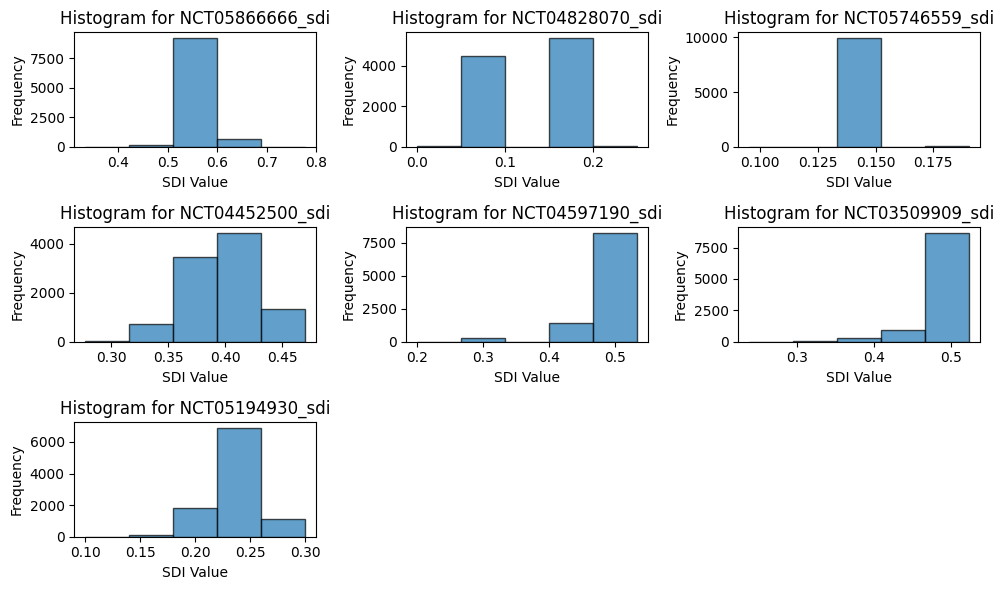

In [20]:
plot_sdi_histograms(sdi_results_df)

# Determining SDI for cohort made using criteria from NCT04828070

In [26]:
df = pd.read_parquet(parquet_files[0])
#Remove unnecessary descriptors from column names that MDClone added
words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)',
                   '(administered)', '-bmi','documentation date-time-days from reference', '-marital status (at update)',' - last recorded','-survey/scale score','-zip code (at update)',
                   '-weight (pounds)','-admitting diagnosis','-immunization','-orderable item',' flag (y/n)']

df.columns = df.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)
df.columns = df.columns.str.strip()
# Convert
df['veteran']  = df['veteran'].apply(lambda x: True if x == 'Yes' else (False if x == 'No' else pd.NA))
df['telithromycin']       = df['telithromycin'].fillna(False).apply(lambda x: True if x else False)
df['borderline diabetes'] = df['borderline diabetes'].fillna(False).apply(lambda x: True if x else False)
df['facebook account']    = df['facebook account'].fillna(False).apply(lambda x: True if x else False)

true_conditions = ['pregnant',
'congenital heart disease',
 'acquired heart disease',
 'valvular heart disease',
 'ischemic heart disease',
 'cardiomyopathy',
 'arrhythmias',
 'peripartum cardiomyopathy',
 'supraventricular tachycardia',
 'pacemaker',
 'electrical assist device',
 'prepregnancy pulmonary hypertension',
 'english speaking',
 'spanish speaking',
 'informed consent']

false_conditions = []

# Reorder columns with true_conditions at the beginning
df = df[true_conditions + [col for col in df.columns if col not in true_conditions]]
df = df.copy()
df['Match'] = 0
df.loc[df[true_conditions].all(axis=1)  & ~df[false_conditions].any(axis=1), 'Match'] = 1
df.loc[~df[true_conditions].all(axis=1) & df[false_conditions].any(axis=1), 'Match'] = -1

df = df.rename(columns={'informed consent': 'consent'})

df

,pregnant,congenital heart disease,acquired heart disease,valvular heart disease,ischemic heart disease,cardiomyopathy,arrhythmias,peripartum cardiomyopathy,...,sleep disorder breathing,ahi,daytime sleepiness,restless leg syndrome,circadian rhythm sleep disorder,prolonged exposure therapy,unstable psychiatric disorders,Match
0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0
2,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24378,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0
24379,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0
24380,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0
24381,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0


In [23]:
trial_names = ["NCT05866666", "NCT04828070","NCT05746559","NCT04452500","NCT04597190","NCT03509909","NCT05194930"]  # These names will be used for columns in the resulting dataframe
current_trial = "NCT04828070"
sdi_results_df = process_trials_and_append(df, criteria_texts_list, trial_names, keys_to_remove, model, tokenizer, entity_types, current_trial)
sdi_results_df

100%|██████████| 10000/10000 [01:11<00:00, 139.13it/s]


,patient id,Match,NCT05866666_sdi,NCT04828070_sdi,NCT05746559_sdi,NCT04452500_sdi,NCT04597190_sdi,NCT03509909_sdi,NCT05194930_sdi,NCT05866666,NCT04828070,NCT05746559,NCT04452500,NCT04597190,NCT03509909,NCT05194930
0,1012241436,0,0.555556,0.166667,0.142857,0.421687,0.466667,0.523810,0.25,0,1,0,0,0,0,0
1,1030383557,0,0.555556,0.166667,0.142857,0.433735,0.466667,0.476190,0.25,0,1,0,0,0,0,0
2,1014231402,0,0.555556,0.166667,0.142857,0.433735,0.466667,0.523810,0.25,0,1,0,0,0,0,0
3,1009171848,0,0.555556,0.250000,0.142857,0.421687,0.466667,0.428571,0.20,0,1,0,0,0,0,0
4,1015371922,0,0.555556,0.166667,0.142857,0.421687,0.466667,0.476190,0.30,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1012244201,0,0.555556,0.166667,0.142857,0.445783,0.466667,0.523810,0.25,0,1,0,0,0,0,0
9996,1018913417,0,0.555556,0.166667,0.142857,0.433735,0.466667,0.523810,0.25,0,1,0,0,0,0,0
9997,1003167258,0,0.666667,0.250000,0.142857,0.373494,0.466667,0.523810,0.25,0,1,0,0,0,0,0
9998,1020126307,0,0.555556,0.166667,0.142857,0.445783,0.533333,0.428571,0.20,0,1,0,0,0,0,0


In [25]:
sdi_results_df.to_csv('/content/drive/MyDrive/NCT04828070_Cohort_SDI_Comparison.csv', index=False)

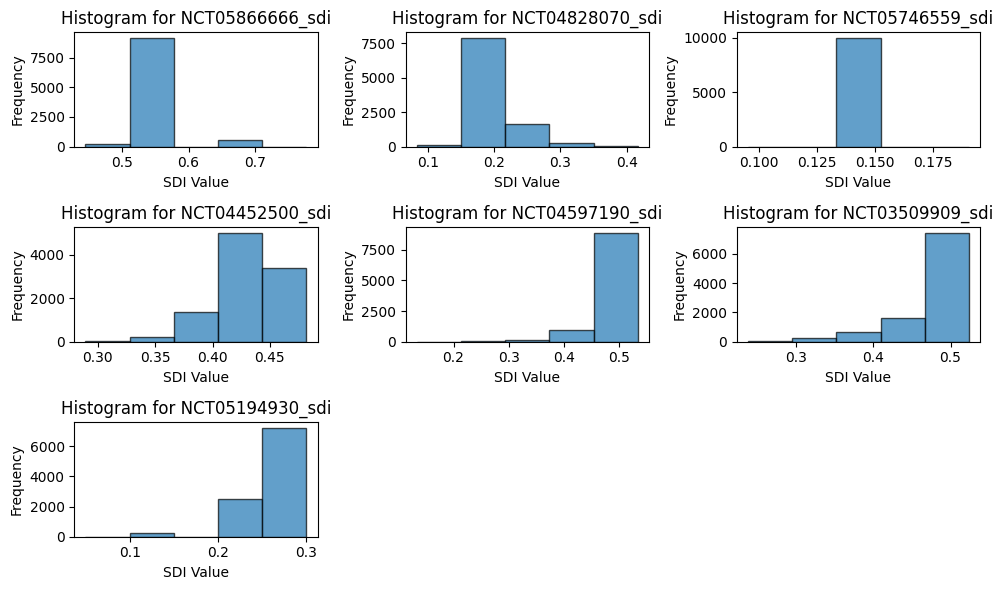

In [24]:
plot_sdi_histograms(sdi_results_df)

# Determining SDI for cohort made using criteria from NCT05746559

In [27]:
df = pd.read_parquet(parquet_files[1])
#Remove unnecessary descriptors from column names that MDClone added
words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)',
                   '(administered)', '-bmi','documentation date-time-days from reference', '-marital status (at update)',' - last recorded','-survey/scale score','-zip code (at update)',
                   '-weight (pounds)','-admitting diagnosis','-immunization','-orderable item',' flag (y/n)']

df.columns = df.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)
df.columns = df.columns.str.strip()
# Convert
df['veteran']  = df['veteran'].apply(lambda x: True if x == 'Yes' else (False if x == 'No' else pd.NA))
df['telithromycin']       = df['telithromycin'].fillna(False).apply(lambda x: True if x else False)
df['borderline diabetes'] = df['borderline diabetes'].fillna(False).apply(lambda x: True if x else False)
df['facebook account']    = df['facebook account'].fillna(False).apply(lambda x: True if x else False)

true_conditions = ["weight",
    "sternotomy",
    "ascending aorta surgery",
    "aortic valve replacement",
    "aortic valve repair",
    "coronary artery bypass grafting",
    "chronic kidney disease"]

false_conditions = [
 'organ recipient',
 'bone marrow transplant',
 'cardiogenic shock',
 'hemodynamic instability',
 'intra-aortic balloon pump',
 'extracorporeal membrane oxygenation',
 'left ventricular assist device',
 'systemic bacterial infection',
 'systemic viral infection',
 'systemic fungal infection',
 'unexplained infection',
 'recurrent infection',
 'kidney replacement therapy',
 'acute kidney injury',
 'complement inhibitors',
 'plasmapheresis',
 'plasma exchange']

# Reorder columns with true_conditions at the beginning
df = df[true_conditions + [col for col in df.columns if col not in true_conditions]]
df = df.copy()
df['Match'] = 0
df.loc[df[true_conditions].all(axis=1)  & ~df[false_conditions].any(axis=1), 'Match'] = 1
df.loc[~df[true_conditions].all(axis=1) & df[false_conditions].any(axis=1), 'Match'] = -1

df = df.rename(columns={'informed consent': 'consent'})

df

,weight,sternotomy,ascending aorta surgery,aortic valve replacement,aortic valve repair,coronary artery bypass grafting,chronic kidney disease,date of birth,...,sleep disorder breathing,ahi,daytime sleepiness,restless leg syndrome,circadian rhythm sleep disorder,prolonged exposure therapy,unstable psychiatric disorders,Match
0,164.199997,True,False,False,False,False,True,0.0,...,False,False,False,False,False,False,False,-1
1,198.000000,True,False,False,False,False,True,0.0,...,False,False,False,False,False,False,False,-1
2,NaN,True,False,False,False,False,False,0.0,...,False,False,False,False,False,False,False,-1
3,255.520004,True,False,False,False,False,True,0.0,...,True,False,False,False,False,False,False,-1
4,205.300003,True,False,False,False,False,True,0.0,...,False,False,False,False,False,False,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,194.009995,True,False,False,False,False,False,0.0,...,False,False,False,False,False,False,False,0
2871,151.399994,True,False,True,False,False,False,0.0,...,False,False,False,False,False,False,False,0
2872,214.949997,True,False,True,False,False,False,0.0,...,True,False,False,False,False,False,False,0
2873,135.300003,True,False,False,False,False,False,0.0,...,True,False,False,False,False,False,False,0


In [28]:
trial_names = ["NCT05866666", "NCT04828070","NCT05746559","NCT04452500","NCT04597190","NCT03509909","NCT05194930"]  # These names will be used for columns in the resulting dataframe
current_trial = "NCT05746559"
sdi_results_df = process_trials_and_append(df, criteria_texts_list, trial_names, keys_to_remove, model, tokenizer, entity_types, current_trial)
sdi_results_df.to_csv('/content/drive/MyDrive/NCT05746559_Cohort_SDI_Comparison.csv', index=False)
sdi_results_df

100%|██████████| 2875/2875 [00:20<00:00, 138.90it/s]


,patient id,Match,NCT05866666_sdi,NCT04828070_sdi,NCT05746559_sdi,NCT04452500_sdi,NCT04597190_sdi,NCT03509909_sdi,NCT05194930_sdi,NCT05866666,NCT04828070,NCT05746559,NCT04452500,NCT04597190,NCT03509909,NCT05194930
0,1010163019,0,0.666667,0.083333,0.190476,0.421687,0.466667,0.523810,0.20,0,0,1,0,0,0,0
1,1009702627,-1,0.555556,0.166667,0.190476,0.361446,0.466667,0.523810,0.25,0,0,1,0,0,0,0
2,1014676859,0,0.555556,0.083333,0.190476,0.397590,0.466667,0.476190,0.25,0,0,1,0,0,0,0
3,1011324007,0,0.555556,0.166667,0.190476,0.397590,0.466667,0.523810,0.25,0,0,1,0,0,0,0
4,1007878615,0,0.555556,0.083333,0.190476,0.385542,0.400000,0.523810,0.20,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,1012361195,0,0.555556,0.166667,0.190476,0.385542,0.400000,0.523810,0.25,0,0,1,0,0,0,0
2871,1003628906,0,0.555556,0.083333,0.190476,0.433735,0.466667,0.523810,0.25,0,0,1,0,0,0,0
2872,1000892371,0,0.555556,0.166667,0.190476,0.337349,0.400000,0.476190,0.20,0,0,1,0,0,0,0
2873,1043300457,0,0.555556,0.166667,0.190476,0.373494,0.533333,0.428571,0.20,0,0,1,0,0,0,0


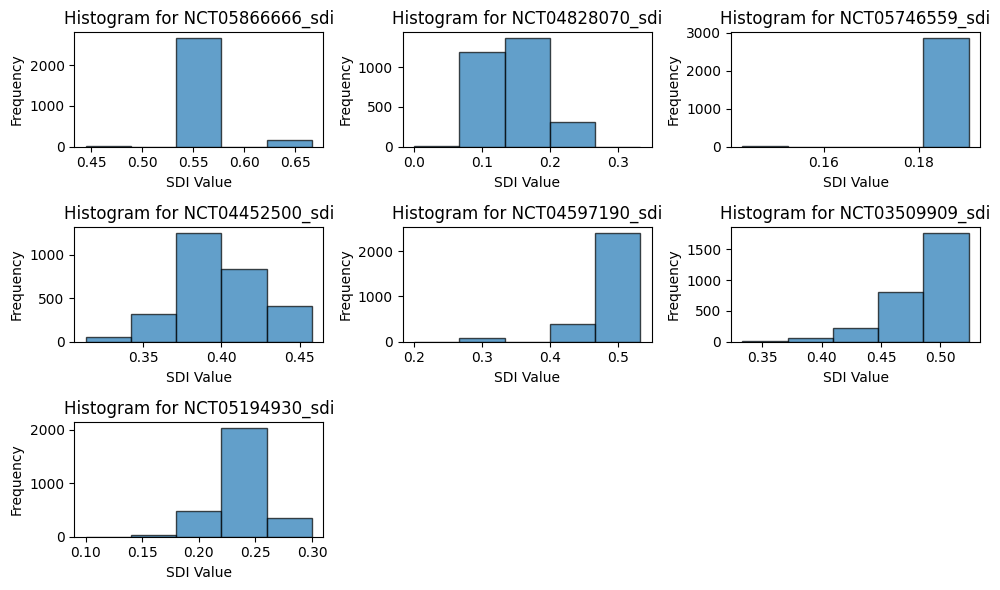

In [29]:
plot_sdi_histograms(sdi_results_df)

# Determining SDI for cohort made using criteria from NCT04452500

In [53]:
df = pd.read_parquet(parquet_files[5])
#Remove unnecessary descriptors from column names that MDClone added
words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)',
                   '(administered)', '-bmi','documentation date-time-days from reference', '-marital status (at update)',' - last recorded','-survey/scale score','-zip code (at update)',
                   '-weight (pounds)','-admitting diagnosis','-immunization','-orderable item',' flag (y/n)']

df.columns = df.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)
df.columns = df.columns.str.strip()
# Convert
df['veteran']  = df['veteran'].apply(lambda x: True if x == 'Yes' else (False if x == 'No' else pd.NA))
df['telithromycin']       = df['telithromycin'].fillna(False).apply(lambda x: True if x else False)
df['borderline diabetes'] = df['borderline diabetes'].fillna(False).apply(lambda x: True if x else False)
df['facebook account']    = df['facebook account'].fillna(False).apply(lambda x: True if x else False)

true_conditions = ['veteran',
 'english speaking',
 'informed consent',
 'combat trauma',
 'military sexual trauma',
 'ptsd',
 'ssri',
 'snri',
 'contraception',
 'trazodone',
 'opiates',
 'psychotherapy']

false_conditions = [
    "alcohol use",
    "marijuana use",
    "drug use disorder",
    "bipolar disorder i",
    "bipolar disorder ii",
    "columbia suicide severity rating scale",
    "schizophrenia",
    "schizoaffective disorder",
    "obsessive compulsive disorder",
    "major depressive disorder with psychotic features",
    "recent trauma exposure",
    "mirtazapine",
    "doxepin",
    "tricyclics",
    "lithium",
    "antipsychotic medication",
    "benzodiazepines",
    "suicidal ideation",
    "homicidal ideation",
    "suicidal behavior",
    "suicide risk",
    "sleep apnea",
    "oral device",
    "corticosteroids",
    "neurologic disorder",
    "systemic illness",
    "unstable angina",
    "myocardial infarction",
    "congestive heart failure",
    "preexisting hypotension",
    "orthostatic hypotension",
    "heart block",
    "pancreatitis",
    "hepatobiliary disease",
    "heart failure",
    "hypokalemia",
    "clarithromycin",
    "telithromycin",
    "nefazodone",
    "itraconazole",
    "ketoconazole",
    "atazanavir",
    "darunavir",
    "indinavir",
    "lopinavir",
    "nelfinavir",
    "ritonavir",
    "saquinavir",
    "tipranavir",
    "diabetes",
    "severe traumatic brain injury",
    "moderate traumatic brain injury",
    "mild cognitive impairment",
    "montreal cognitive assessment",
    "cpap",
    "cns disease",
    "ast",
    "alt",
    "prolonged qtc",
    "torsades de pointes",
    "long qt syndrome",
    "mild cognitive impairment",
]

# Reorder columns with true_conditions at the beginning
df = df[true_conditions + [col for col in df.columns if col not in true_conditions]]
df = df.copy()
df['Match'] = 0
df.loc[df[true_conditions].all(axis=1)  & ~df[false_conditions].any(axis=1), 'Match'] = 1
df.loc[~df[true_conditions].all(axis=1) & df[false_conditions].any(axis=1), 'Match'] = -1

df = df.rename(columns={'informed consent': 'consent','veteran':'military service'})

df

,military service,english speaking,consent,combat trauma,military sexual trauma,ptsd,ssri,snri,...,sleep disorder breathing,ahi,daytime sleepiness,restless leg syndrome,circadian rhythm sleep disorder,prolonged exposure therapy,unstable psychiatric disorders,Match
0,True,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,-1
1,True,False,False,False,False,True,False,False,...,True,False,True,False,False,False,False,-1
2,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,-1
3,True,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,-1
4,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584028,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,0
584029,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,-1
584030,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,-1
584031,True,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,-1


In [54]:
trial_names = ["NCT05866666", "NCT04828070","NCT05746559","NCT04452500","NCT04597190","NCT03509909","NCT05194930"]  # These names will be used for columns in the resulting dataframe
current_trial = "NCT04452500"
sdi_results_df = process_trials_and_append(df, criteria_texts_list, trial_names, keys_to_remove, model, tokenizer, entity_types, current_trial)
sdi_results_df.to_csv('/content/drive/MyDrive/NCT04452500_Cohort_SDI_Comparison.csv', index=False)
sdi_results_df

100%|██████████| 10000/10000 [01:13<00:00, 136.36it/s]


,patient id,Match,NCT05866666_sdi,NCT04828070_sdi,NCT05746559_sdi,NCT04452500_sdi,NCT04597190_sdi,NCT03509909_sdi,NCT05194930_sdi,NCT05866666,NCT04828070,NCT05746559,NCT04452500,NCT04597190,NCT03509909,NCT05194930
0,1012209246,-1,0.555556,0.083333,0.142857,0.469880,0.533333,0.476190,0.20,0,0,0,1,0,0,0
1,1019522150,-1,0.555556,0.083333,0.142857,0.445783,0.466667,0.428571,0.25,0,0,0,1,0,0,0
2,1026957908,-1,0.555556,0.083333,0.142857,0.469880,0.533333,0.476190,0.20,0,0,0,1,0,0,0
3,1014458853,-1,0.555556,0.083333,0.142857,0.445783,0.533333,0.380952,0.20,0,0,0,1,0,0,0
4,1016628239,0,0.555556,0.083333,0.142857,0.481928,0.533333,0.476190,0.20,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1011848130,-1,0.555556,0.083333,0.142857,0.445783,0.533333,0.476190,0.25,0,0,0,1,0,0,0
9996,1005761593,-1,0.555556,0.083333,0.142857,0.457831,0.533333,0.333333,0.20,0,0,0,1,0,0,0
9997,1046342368,-1,0.555556,0.083333,0.142857,0.445783,0.533333,0.428571,0.20,0,0,0,1,0,0,0
9998,1018432522,-1,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.20,0,0,0,1,0,0,0


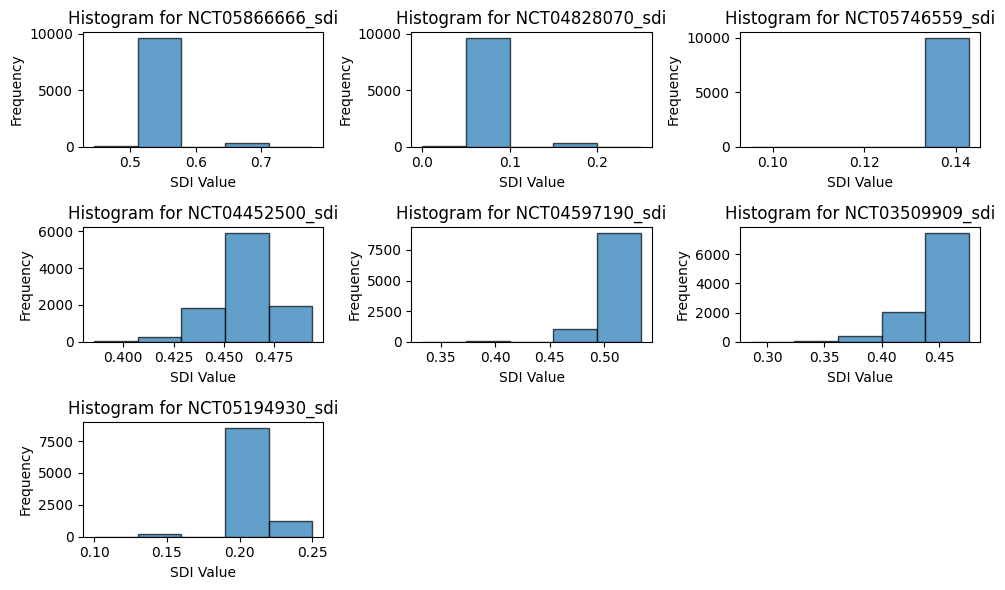

In [55]:
plot_sdi_histograms(sdi_results_df)

# Determining SDI for cohort made using criteria from NCT04597190

In [35]:
df = pd.read_parquet(parquet_files[2])
#Remove unnecessary descriptors from column names that MDClone added
words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)',
                   '(administered)', '-bmi','documentation date-time-days from reference', '-marital status (at update)',' - last recorded','-survey/scale score','-zip code (at update)',
                   '-weight (pounds)','-admitting diagnosis','-immunization','-orderable item',' flag (y/n)']

df.columns = df.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)
df.columns = df.columns.str.strip()
# Convert
df['veteran']  = df['veteran'].apply(lambda x: True if x == 'Yes' else (False if x == 'No' else pd.NA))
df['telithromycin']       = df['telithromycin'].fillna(False).apply(lambda x: True if x else False)
df['borderline diabetes'] = df['borderline diabetes'].fillna(False).apply(lambda x: True if x else False)
df['facebook account']    = df['facebook account'].fillna(False).apply(lambda x: True if x else False)

true_conditions = ["ptsd",
    "combat trauma"]

false_conditions = [
    "schizophrenia",
    "schizoaffective disorder",
    "bipolar disorder i",
    "dementia",
    "venlafaxine",
    "psychotropic prescription",
    "specialty mental health",
    "pregnant",
    "terminally ill",
    "english speaking",
    "spanish speaking",
    "impaired decision making"
]

# Reorder columns with true_conditions at the beginning
df = df[true_conditions + [col for col in df.columns if col not in true_conditions]]
df = df.copy()
df['Match'] = 0
df.loc[df[true_conditions].all(axis=1)  & ~df[false_conditions].any(axis=1), 'Match'] = 1
df.loc[~df[true_conditions].all(axis=1) & df[false_conditions].any(axis=1), 'Match'] = -1

df = df.rename(columns={'informed consent': 'consent','veteran':'military service'})

df

,ptsd,combat trauma,date of birth,gender at birth,races,military service,ethnicity,patient id,...,sleep disorder breathing,ahi,daytime sleepiness,restless leg syndrome,circadian rhythm sleep disorder,prolonged exposure therapy,unstable psychiatric disorders,Match
0,True,False,0.0,Male,Black or African American,True,Not Hispanic or Latino,1000678757,...,False,False,False,False,False,False,False,0
1,True,False,0.0,Male,White,True,Not Hispanic or Latino,1000684928,...,False,False,False,False,False,False,False,0
2,True,False,0.0,Male,White,True,Not Hispanic or Latino,1000686022,...,False,False,False,False,False,False,False,0
3,True,False,0.0,Female,White,True,Not Hispanic or Latino,1000704281,...,False,False,False,False,False,False,False,-1
4,True,False,0.0,Male,White,True,Not Hispanic or Latino,1000730514,...,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990814,True,False,0.0,Male,White,True,None,1054899303,...,False,False,False,False,False,False,False,0
990815,True,False,0.0,Male,White,True,None,1055249923,...,False,False,False,False,False,False,False,0
990816,True,False,0.0,Male,Black or African American,True,None,1056158070,...,False,False,False,False,False,False,False,0
990817,True,False,0.0,Male,Asian ; Black or African American ; Native...,True,None,1056433821,...,False,False,False,False,False,False,False,0


In [36]:
trial_names = ["NCT05866666", "NCT04828070","NCT05746559","NCT04452500","NCT04597190","NCT03509909","NCT05194930"]  # These names will be used for columns in the resulting dataframe
current_trial = "NCT04597190"
sdi_results_df = process_trials_and_append(df, criteria_texts_list, trial_names, keys_to_remove, model, tokenizer, entity_types, current_trial)
sdi_results_df.to_csv('/content/drive/MyDrive/NCT04597190_Cohort_SDI_Comparison.csv', index=False)
sdi_results_df

100%|██████████| 10000/10000 [01:13<00:00, 136.79it/s]


,patient id,Match,NCT05866666_sdi,NCT04828070_sdi,NCT05746559_sdi,NCT04452500_sdi,NCT04597190_sdi,NCT03509909_sdi,NCT05194930_sdi,NCT05866666,NCT04828070,NCT05746559,NCT04452500,NCT04597190,NCT03509909,NCT05194930
0,1005357830,0,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.20,0,0,0,0,1,0,0
1,1017788027,0,0.555556,0.083333,0.142857,0.469880,0.533333,0.476190,0.20,0,0,0,0,1,0,0
2,1009536559,-1,0.555556,0.083333,0.142857,0.433735,0.533333,0.476190,0.20,0,0,0,0,1,0,0
3,1030874283,0,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.25,0,0,0,0,1,0,0
4,1015367435,0,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.20,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1008539167,0,0.555556,0.083333,0.142857,0.469880,0.533333,0.476190,0.20,0,0,0,0,1,0,0
9996,1027402822,-1,0.666667,0.083333,0.142857,0.397590,0.400000,0.333333,0.20,0,0,0,0,1,0,0
9997,1004728818,0,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.20,0,0,0,0,1,0,0
9998,1019234927,-1,0.555556,0.083333,0.142857,0.469880,0.533333,0.476190,0.20,0,0,0,0,1,0,0


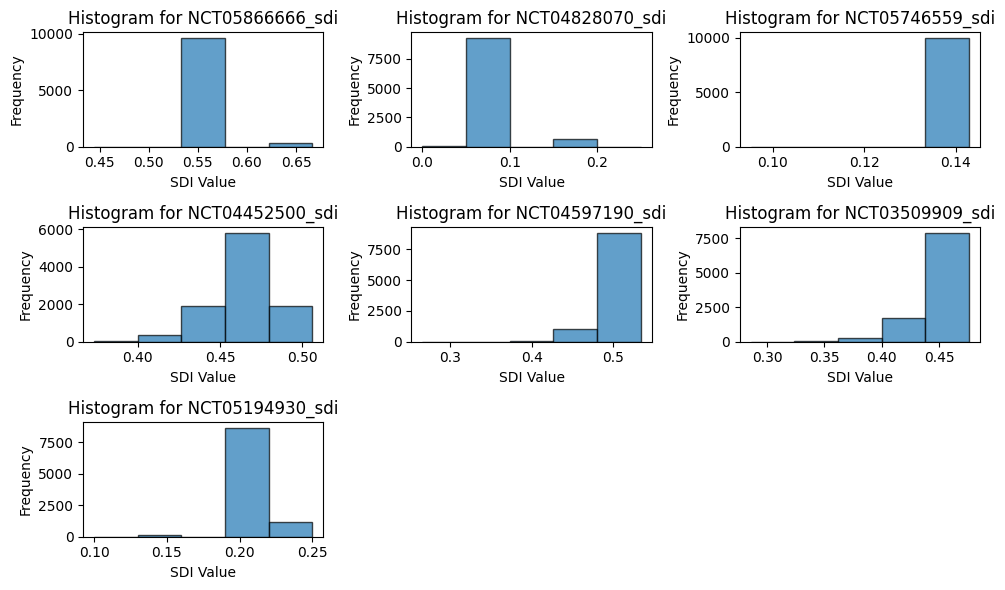

In [37]:
plot_sdi_histograms(sdi_results_df)

# Determining SDI for cohort made using criteria from NCT03509909

In [39]:
df = pd.read_parquet(parquet_files[3])
#Remove unnecessary descriptors from column names that MDClone added
words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)',
                   '(administered)', '-bmi','documentation date-time-days from reference', '-marital status (at update)',' - last recorded','-survey/scale score','-zip code (at update)',
                   '-weight (pounds)','-admitting diagnosis','-immunization','-orderable item',' flag (y/n)']

df.columns = df.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)
df.columns = df.columns.str.strip()
# Convert
df['veteran']  = df['veteran'].apply(lambda x: True if x == 'Yes' else (False if x == 'No' else pd.NA))
df['telithromycin']       = df['telithromycin'].fillna(False).apply(lambda x: True if x else False)
df['borderline diabetes'] = df['borderline diabetes'].fillna(False).apply(lambda x: True if x else False)
df['facebook account']    = df['facebook account'].fillna(False).apply(lambda x: True if x else False)

true_conditions = ["ptsd",
    "veteran"]

false_conditions = [
   "suicidal ideation",
    "homicidal ideation",
    "substance abuse",
    "substance dependence",
    "mental disorders",
    "psychotic disorders",
    "bipolar disorder i",
    "dissociative symptoms",
    "cognitive impairment",
    "violent relationship",
    "pregnant",
    "enrollment in clinical trial",
    "meditation",
    "yoga practice",
    "mind-body intervention"
]

# Reorder columns with true_conditions at the beginning
df = df[true_conditions + [col for col in df.columns if col not in true_conditions]]
df = df.copy()
df['Match'] = 0
df.loc[df[true_conditions].all(axis=1)  & ~df[false_conditions].any(axis=1), 'Match'] = 1
df.loc[~df[true_conditions].all(axis=1) & df[false_conditions].any(axis=1), 'Match'] = -1

df = df.rename(columns={'informed consent': 'consent'})

df

,ptsd,veteran,date of birth,gender at birth,races,ethnicity,patient id,ptsd-ref-age when condition was documented,...,sleep disorder breathing,ahi,daytime sleepiness,restless leg syndrome,circadian rhythm sleep disorder,prolonged exposure therapy,unstable psychiatric disorders,Match
0,True,True,0.0,Male,Black or African American,Not Hispanic or Latino,1000651695,70.976076,...,False,False,False,False,False,False,False,1
1,True,True,0.0,Male,White,Not Hispanic or Latino,1000657578,75.996331,...,False,False,False,False,False,False,False,0
2,True,True,0.0,Male,White,Hispanic or Latino,1000668228,72.942772,...,True,False,False,False,False,False,False,1
3,True,True,0.0,Male,Black or African American,Not Hispanic or Latino,1000678185,62.909542,...,False,False,False,False,False,False,False,1
4,True,True,0.0,Male,White,Not Hispanic or Latino,1000678866,71.037905,...,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989610,True,True,0.0,Male,White,None,1055940292,42.162534,...,False,False,False,False,False,False,False,0
989611,True,True,0.0,Male,None,None,1056545535,23.013737,...,False,False,False,False,False,False,False,1
989612,True,True,0.0,Male,White,None,1058693656,27.826778,...,False,False,False,False,False,False,False,0
989613,True,True,0.0,Male,None,None,1058811967,37.505928,...,True,False,False,False,False,False,False,0


In [40]:
trial_names = ["NCT05866666", "NCT04828070","NCT05746559","NCT04452500","NCT04597190","NCT03509909","NCT05194930"]  # These names will be used for columns in the resulting dataframe
current_trial = "NCT03509909"
sdi_results_df = process_trials_and_append(df, criteria_texts_list, trial_names, keys_to_remove, model, tokenizer, entity_types, current_trial)
sdi_results_df.to_csv('/content/drive/MyDrive/NCT03509909_Cohort_SDI_Comparison.csv', index=False)
sdi_results_df

100%|██████████| 10000/10000 [01:12<00:00, 137.75it/s]


,patient id,Match,NCT05866666_sdi,NCT04828070_sdi,NCT05746559_sdi,NCT04452500_sdi,NCT04597190_sdi,NCT03509909_sdi,NCT05194930_sdi,NCT05866666,NCT04828070,NCT05746559,NCT04452500,NCT04597190,NCT03509909,NCT05194930
0,1005624792,1,0.555556,0.166667,0.142857,0.421687,0.533333,0.476190,0.20,0,0,0,0,0,1,0
1,1014262059,1,0.555556,0.083333,0.142857,0.469880,0.533333,0.476190,0.20,0,0,0,0,0,1,0
2,1028991143,1,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.25,0,0,0,0,0,1,0
3,1006346194,1,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.20,0,0,0,0,0,1,0
4,1017919919,0,0.555556,0.083333,0.142857,0.469880,0.533333,0.428571,0.20,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1017332790,1,0.555556,0.083333,0.142857,0.469880,0.533333,0.476190,0.20,0,0,0,0,0,1,0
9996,1034343944,0,0.555556,0.166667,0.142857,0.409639,0.533333,0.428571,0.20,0,0,0,0,0,1,0
9997,1015590208,1,0.555556,0.083333,0.142857,0.469880,0.533333,0.476190,0.20,0,0,0,0,0,1,0
9998,1015771130,0,0.555556,0.083333,0.142857,0.433735,0.466667,0.476190,0.25,0,0,0,0,0,1,0


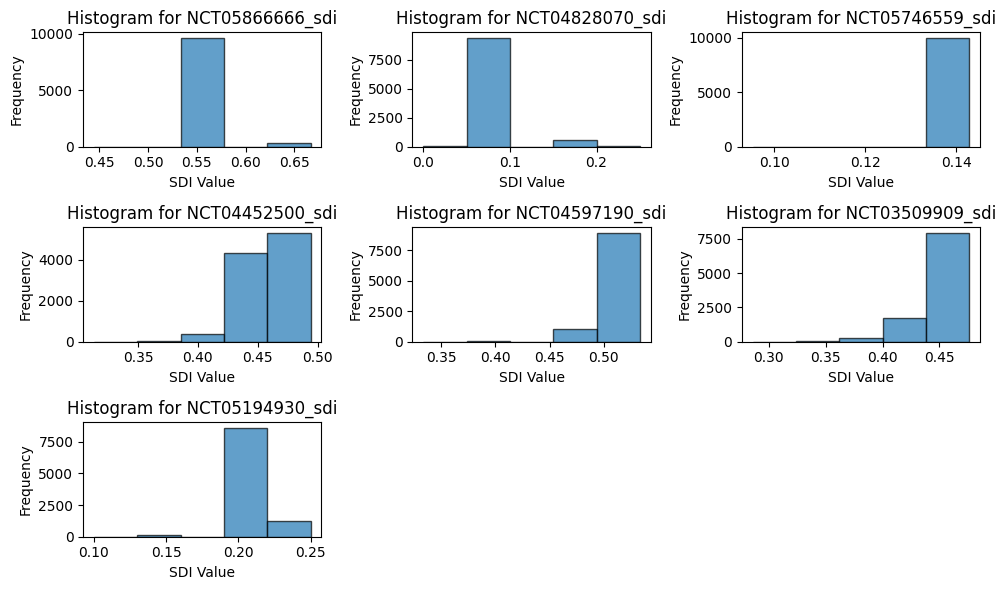

In [41]:
plot_sdi_histograms(sdi_results_df)

# Determining SDI for cohort made using criteria from NCT05194930

In [46]:
df = pd.read_parquet(parquet_files[4])
#Remove unnecessary descriptors from column names that MDClone added
words_to_remove = ['-condition', '-health factor', '-result numeric (original)', '-medication', '-interpretation', '-procedure', '-lab test', '-medication (administered)',
                   '(administered)', '-bmi','documentation date-time-days from reference', '-marital status (at update)',' - last recorded','-survey/scale score','-zip code (at update)',
                   '-weight (pounds)','-admitting diagnosis','-immunization','-orderable item',' flag (y/n)']

df.columns = df.columns.str.replace('|'.join(map(re.escape, words_to_remove)), '', regex=True)
df.columns = df.columns.str.strip()
# Convert
df['veteran_x']  = df['veteran_x'].apply(lambda x: True if x == 'Yes' else (False if x == 'No' else pd.NA))
df['telithromycin']       = df['telithromycin'].fillna(False).apply(lambda x: True if x else False)
df['borderline diabetes'] = df['borderline diabetes'].fillna(False).apply(lambda x: True if x else False)
df['facebook account']    = df['facebook account'].fillna(False).apply(lambda x: True if x else False)

true_conditions = ["community dwelling",
    "veteran_x",
    "ptsd",
    "insomnia"]

false_conditions = [
   "pregnant",
    "has child 6 months",
    "substance abuse",
    "sobriety",
    "too ill",
    "informed consent",
    "unstable housing",
    "sleep disorder breathing",
    "ahi",
    "daytime sleepiness",
    "restless leg syndrome",
    "circadian rhythm sleep disorder",
    "unstable psychiatric disorders",
    "prolonged exposure therapy"
]

# Reorder columns with true_conditions at the beginning
df = df[true_conditions + [col for col in df.columns if col not in true_conditions]]
df = df.copy()
df['Match'] = 0
df.loc[df[true_conditions].all(axis=1)  & ~df[false_conditions].any(axis=1), 'Match'] = 1
df.loc[~df[true_conditions].all(axis=1) & df[false_conditions].any(axis=1), 'Match'] = -1

df = df.rename(columns={'informed consent': 'consent','veteran_x':'veteran'}).drop('veteran_y',axis=1)

df

,community dwelling,veteran,ptsd,insomnia,date of birth,gender at birth,races,ethnicity,...,sleep disorder breathing,ahi,daytime sleepiness,restless leg syndrome,circadian rhythm sleep disorder,prolonged exposure therapy,unstable psychiatric disorders,Match
0,True,NaN,True,False,0.0,Female,Black or African American ; Declined to answer,None,...,False,False,False,False,False,False,False,0
1,True,NaN,True,False,0.0,Male,White,Not Hispanic or Latino,...,False,False,False,False,False,False,False,0
2,False,NaN,True,False,0.0,Female,White,Not Hispanic or Latino,...,False,False,False,False,False,False,False,0
3,False,NaN,True,False,0.0,Male,Black or African American,Not Hispanic or Latino,...,True,False,False,False,False,False,False,-1
4,False,NaN,True,False,0.0,Male,Black or African American,Not Hispanic or Latino,...,True,False,False,False,False,False,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487148,False,NaN,True,True,0.0,Male,None,None,...,True,False,False,False,False,False,False,-1
487149,False,NaN,True,True,0.0,Female,White,None,...,False,False,False,False,False,False,False,0
487150,False,NaN,True,True,0.0,Male,Declined to answer,None,...,False,False,False,False,False,False,False,0
487151,False,NaN,True,True,0.0,Male,None,None,...,False,False,False,False,False,False,False,0


In [48]:
trial_names = ["NCT05866666", "NCT04828070","NCT05746559","NCT04452500","NCT04597190","NCT03509909","NCT05194930"]  # These names will be used for columns in the resulting dataframe
current_trial = "NCT05194930"
sdi_results_df = process_trials_and_append(df, criteria_texts_list, trial_names, keys_to_remove, model, tokenizer, entity_types, current_trial)
sdi_results_df.to_csv('/content/drive/MyDrive/NCT05194930_Cohort_SDI_Comparison.csv', index=False)
sdi_results_df

100%|██████████| 10000/10000 [01:13<00:00, 136.64it/s]


,patient id,Match,NCT05866666_sdi,NCT04828070_sdi,NCT05746559_sdi,NCT04452500_sdi,NCT04597190_sdi,NCT03509909_sdi,NCT05194930_sdi,NCT05866666,NCT04828070,NCT05746559,NCT04452500,NCT04597190,NCT03509909,NCT05194930
0,1019727011,0,0.555556,0.083333,0.142857,0.445783,0.533333,0.476190,0.20,0,0,0,0,0,0,1
1,1005842043,0,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.20,0,0,0,0,0,0,1
2,1007721968,0,0.555556,0.083333,0.142857,0.469880,0.466667,0.428571,0.15,0,0,0,0,0,0,1
3,1001640019,0,0.555556,0.083333,0.142857,0.445783,0.533333,0.476190,0.20,0,0,0,0,0,0,1
4,1013037872,1,0.555556,0.083333,0.142857,0.445783,0.533333,0.476190,0.25,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1004369903,-1,0.555556,0.083333,0.142857,0.469880,0.533333,0.428571,0.20,0,0,0,0,0,0,1
9996,1007521493,-1,0.555556,0.083333,0.142857,0.421687,0.533333,0.476190,0.20,0,0,0,0,0,0,1
9997,1023763128,0,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.25,0,0,0,0,0,0,1
9998,1001458678,-1,0.555556,0.083333,0.142857,0.445783,0.466667,0.476190,0.20,0,0,0,0,0,0,1


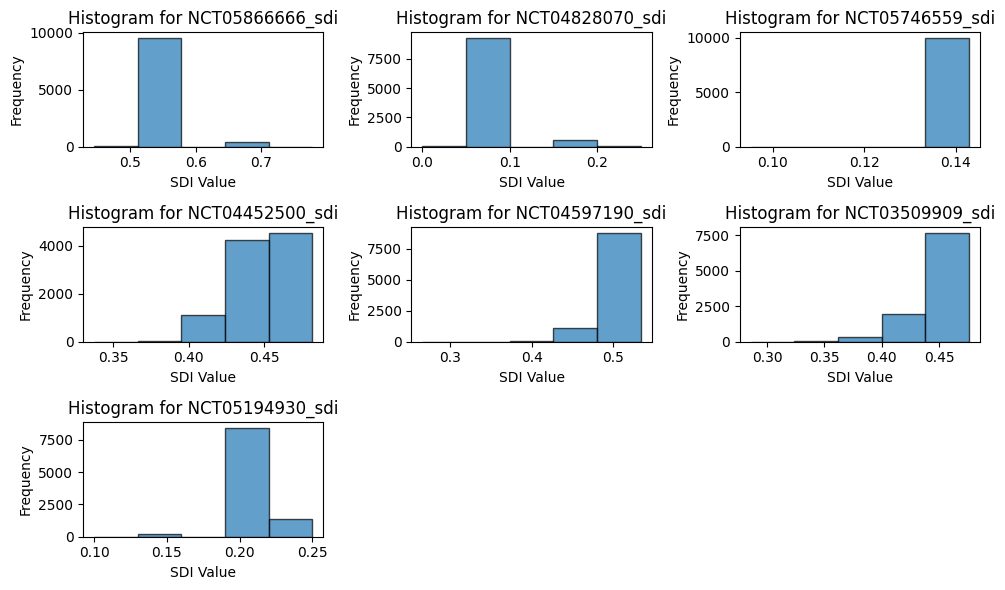

In [49]:
plot_sdi_histograms(sdi_results_df)

# Generating File for ROC Analysis

In [56]:
def concatenate_csvs_in_directory(directory):
    """
    Find all .csv files in a given directory that contain 'NCT' and 'SDI' in their name,
    print the number of rows in each file, and concatenate them into a single pandas DataFrame.
    """
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out files that are .csv and contain 'NCT' and 'SDI' in their name
    relevant_files = [file for file in files if file.endswith('.csv') and 'NCT' in file and 'SDI' in file]

    dataframes = []

    for file in relevant_files:
        df = pd.read_csv(os.path.join(directory, file))

        # Print the number of rows for each DataFrame
        print(f"File {file} has {len(df)} rows.")

        dataframes.append(df)

    # Concatenate all dataframes
    concatenated_df = pd.concat(dataframes, ignore_index=True)

    return concatenated_df

# Usage
directory = '/content/drive/MyDrive'
roc_df = concatenate_csvs_in_directory(directory)
roc_df

File NCT05866666_Cohort_SDI_Comparison.csv has 10000 rows.
File NCT04828070_Cohort_SDI_Comparison.csv has 10000 rows.
File NCT05746559_Cohort_SDI_Comparison.csv has 2875 rows.
File NCT04452500_Cohort_SDI_Comparison.csv has 10000 rows.
File NCT04597190_Cohort_SDI_Comparison.csv has 10000 rows.
File NCT03509909_Cohort_SDI_Comparison.csv has 10000 rows.
File NCT05194930_Cohort_SDI_Comparison.csv has 10000 rows.


,patient id,Match,NCT05866666_sdi,NCT04828070_sdi,NCT05746559_sdi,NCT04452500_sdi,NCT04597190_sdi,NCT03509909_sdi,NCT05194930_sdi,NCT05866666,NCT04828070,NCT05746559,NCT04452500,NCT04597190,NCT03509909,NCT05194930
0,1003988674,0,0.555556,0.083333,0.142857,0.385542,0.466667,0.476190,0.25,1,0,0,0,0,0,0
1,1003218910,0,0.555556,0.166667,0.142857,0.409639,0.466667,0.523810,0.25,1,0,0,0,0,0,0
2,1020098355,0,0.555556,0.083333,0.142857,0.445783,0.533333,0.476190,0.20,1,0,0,0,0,0,0
3,1016964938,0,0.555556,0.166667,0.142857,0.373494,0.466667,0.476190,0.25,1,0,0,0,0,0,0
4,1000976180,0,0.555556,0.166667,0.142857,0.361446,0.400000,0.523810,0.25,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62870,1004369903,-1,0.555556,0.083333,0.142857,0.469880,0.533333,0.428571,0.20,0,0,0,0,0,0,1
62871,1007521493,-1,0.555556,0.083333,0.142857,0.421687,0.533333,0.476190,0.20,0,0,0,0,0,0,1
62872,1023763128,0,0.555556,0.083333,0.142857,0.457831,0.533333,0.476190,0.25,0,0,0,0,0,0,1
62873,1001458678,-1,0.555556,0.083333,0.142857,0.445783,0.466667,0.476190,0.20,0,0,0,0,0,0,1


In [60]:
# Get the max value for each 'SDI' column
sdi_max_values = roc_df.filter(like='sdi').max()
sdi_max_values

NCT05866666_sdi    0.777778
NCT04828070_sdi    0.416667
NCT05746559_sdi    0.190476
NCT04452500_sdi    0.506024
NCT04597190_sdi    0.533333
NCT03509909_sdi    0.523810
NCT05194930_sdi    0.300000
dtype: float64

In [57]:
roc_df.to_csv('/content/drive/MyDrive/CTM_ROC_SDI_Analysis.csv', index=False)

# Old Stuff

In [ ]:
criteria_text = """
Inclusion Criteria:

    Veterans who have clinically meaningful PTSD symptoms

Exclusion Criteria:

    serious suicidality or homicidality that has required urgent or emergent evaluation or treatment within the past three months

    a known, untreated substance abuse or dependence problem
        inclusion is possible if there is evidence that the individual has been afforded and is complying with treatment for the substance problem
    serious mental disorders, such as psychotic disorders or bipolar type I, or serious dissociative symptoms
    cognitive impairment that would interfere with treatment

    circumstances that lead to recurrent traumatization
        e.g., engaged in a violent relationship
    any medical condition for which exercise is contraindicated, including pregnancy

    concurrent enrollment in any other treatment specifically targeting PTSD symptoms or in any meditative or mind-body intervention
        including yoga practice >1 class/month in the preceding 6 months
"""

entity_types = ['Disease_disorder', 'Medication', 'Diagnostic_procedure','Sign_symptom','History','Nonbiological_location','Clinical_event','Therapeutic_procedure','Activity'] #Only keep entities of these types

keys_to_remove = []

eligibility_criteria_dict,inclusion_df,exclusion_df,NCT05866666_subset = clinical_trial_matching_v2(df,criteria_text,keys_to_remove, model, tokenizer,entity_types,10000,fm_threshold=60)
NCT05866666_subset['sdi'].max()
#visualize_bool_value_differences_and_histogram_slider(eligibility_criteria_dict, cohort_subset, 'NCT05866666')

In [108]:
inclusion_df

,index,Criteria,entities,entity_group,score,word,combined_word
0,0,Ability to provide written informed consent,"{'entity_group': 'Diagnostic_procedure', 'scor...",Diagnostic_procedure,0.528858,consent,consent
1,3,Referred for cardiac catheterization for reaso...,"{'entity_group': 'Sign_symptom', 'score': 0.87...",Sign_symptom,0.873751,shortness of breath,shortness of breath


In [109]:
exclusion_df

,index,Criteria,entities,entity_group,score,word,combined_word
0,0,Previous Heart Transplant,"{'entity_group': 'Therapeutic_procedure', 'sco...",Therapeutic_procedure,0.995972,heart transplant,heart transplant
1,1,Presence of Left Ventricular Assist Device,"{'entity_group': 'Therapeutic_procedure', 'sco...",Therapeutic_procedure,0.783815,left ventricular assist device,left ventricular assist device
2,2,Presence of a Holter monitor or any other elec...,"{'entity_group': 'Diagnostic_procedure', 'scor...",Diagnostic_procedure,0.990936,holter monitor,holter monitor
3,3,Presence of a Holter monitor or any other elec...,"{'entity_group': 'Sign_symptom', 'score': 0.98...",Sign_symptom,0.988412,electrical leads,electrical leads
4,5,Presence of a Holter monitor or any other elec...,"{'entity_group': 'Clinical_event', 'score': 0....",Clinical_event,0.998179,placement,placement
5,7,Surgical scars/wounds/bandages/ports at the si...,"{'entity_group': 'Sign_symptom', 'score': 0.70...",Sign_symptom,0.706783,scars,scars
6,8,Surgical scars/wounds/bandages/ports at the si...,"{'entity_group': 'Sign_symptom', 'score': 0.74...",Sign_symptom,0.745296,wounds,wounds


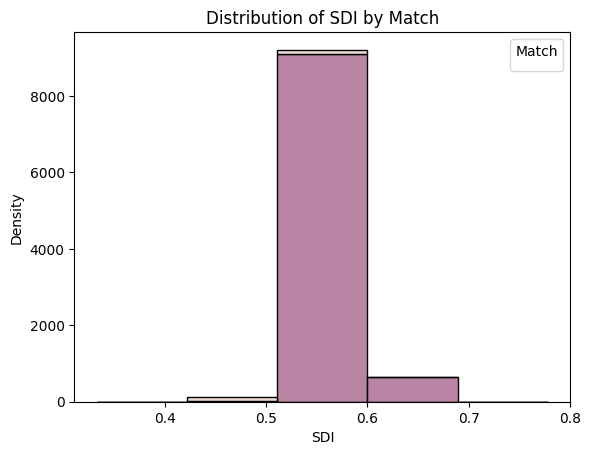

In [110]:
# Assuming you have your dataframe named cohort_subset
sns.histplot(data=cohort_subset, x='sdi', bins=5, edgecolor='black', hue='Match', multiple='stack', alpha=0.8)
plt.title('Distribution of SDI by Match')
plt.xlabel('SDI')
plt.ylabel('Density')
plt.legend(title='Match', loc='upper right') # Customized legend with title and location
plt.show()

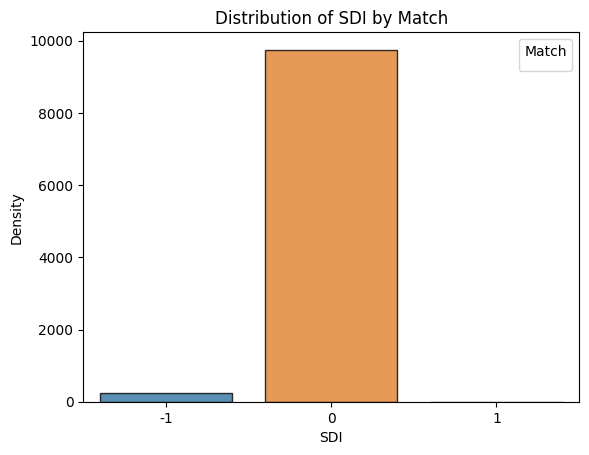

In [111]:
# Assume your dataframe is called results_df
sns.countplot(data=cohort_subset, x='Match', edgecolor='black', alpha=0.8)

plt.title('Distribution of SDI by Match')
plt.xlabel('SDI')
plt.ylabel('Density')
plt.legend(title='Match')
plt.show()

In [112]:
eligibility_criteria_dict

{'consent': True,
 'shortness of breath': True,
 'heart transplant': False,
 'left ventricular assist device': False,
 'holter monitor': False,
 'electrical leads': False,
 'placement': False,
 'scars': False,
 'wounds': False}

In [113]:
cohort_subset['standardized_profile'][1]

{'consent': False,
 'shortness of breath': False,
 'heart transplant': False,
 'left ventricular assist device': False,
 'holter monitor': False,
 'electrical leads': False,
 'placement': nan,
 'scars': nan,
 'wounds': False}

In [ ]:
def run_ner_on_criteria2(criteria_df, model, tokenizer,criteria,entity_types,score_threshold=0.2,keys_to_remove=[]):
    # Define NER pipeline
    pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="average") #Might be worth rtying a different aggregation strategy ("simple" "first" "max" "average")
    # Define a function that takes a piece of text and returns model predictions
    def get_entities(text):
        result = pipe(text)
        return result

    # Apply NER to the 'Criteria' column
    criteria_df['entities'] = criteria_df['Criteria'].apply(get_entities)

    # Explode the 'entities' column into separate rows
    criteria_df = criteria_df.explode('entities')

    # Create new columns
    criteria_df['entity_group'] = criteria_df['entities'].apply(lambda x: x['entity_group'] if pd.notnull(x) else None)
    criteria_df['score'] = criteria_df['entities'].apply(lambda x: x['score'] if pd.notnull(x) else None)
    criteria_df['word'] = criteria_df['entities'].apply(lambda x: x['word'] if pd.notnull(x) else None)
    criteria_df = criteria_df.reset_index(drop=True)

    return criteria_df

In [ ]:
#visualize_bool_value_differences_and_histogram_slider(eligibility_criteria_dict, cohort_subset, 'NCT05866666')

# Check Entities Extracted by Model

In [ ]:
trial_list = ['NCT03509909','NCT04452500','NCT04597190','NCT04828070','NCT05194930','NCT05720611','NCT05746559','NCT05866666']
len(trial_list)

8

In [118]:
criteria_text = """
Inclusion Criteria:

    Veterans who have clinically meaningful PTSD symptoms

Exclusion Criteria:

    serious suicidality or homicidality that has required urgent or emergent evaluation or treatment within the past three months

    a known, untreated substance abuse or dependence problem
        inclusion is possible if there is evidence that the individual has been afforded and is complying with treatment for the substance problem
    serious mental disorders, such as psychotic disorders or bipolar type I, or serious dissociative symptoms
    cognitive impairment that would interfere with treatment

    circumstances that lead to recurrent traumatization
        e.g., engaged in a violent relationship
    any medical condition for which exercise is contraindicated, including pregnancy

    concurrent enrollment in any other treatment specifically targeting PTSD symptoms or in any meditative or mind-body intervention
        including yoga practice >1 class/month in the preceding 6 months
"""

inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}
print(len(eligibility_criteria_dict))
eligibility_criteria_dict

<ipython-input-115-2c2170f40e1b>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


21


<ipython-input-115-2c2170f40e1b>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


{'ptsd symptoms': True,
 'suicidality': False,
 'homicidality': False,
 'evaluation': False,
 'treatment': False,
 'untreated substance abuse': False,
 'dependence problem': False,
 'substance problem': False,
 'mental': False,
 'psychotic disorders': False,
 'bipolar type i': False,
 'dissociative symptoms': False,
 'cognitive impairment': False,
 'traumatization': False,
 'engaged in a violent relationship': False,
 'exercise': False,
 'pregnancy': False,
 'ptsd': False,
 'med': False,
 'mindbody intervention': False,
 'yoga practice': False}

In [ ]:
criteria_text = """
Inclusion Criteria:

    History of US military service
    Capable of reading and understanding English
    Able to provide written informed consent
    Criterion A event meets DSM-5 criteria and occurred during military service, including combat and military sexual trauma
    Chronic full syndromal PTSD diagnosis >3 months duration as indexed by CAPS-5 at screening, and CAPS-5 score > 26 CAPS-5 total score for the past week at baseline
    Participants (male or pre-menopausal females) agree to use two forms of reliable contraception, one of which is a barrier method
    Participants may be on a stable dose (8 weeks at minimum) of an SSRI or SNRI for treatment of their PTSD
    Participants may be on a stable dose of trazodone for sleep maintenance.
    If pain medications are required (opiates), the dose must be stable for 4 weeks at minimum
    For participants who are in psychotherapy, treatment must be stable for 6 weeks

Exclusion Criteria:

    DSM-5 alcohol, marijuana, and/or other drug use disorder in the last 3 months
        Mild alcohol and marijuana use not meeting criteria for use disorder will be allowed
    Lifetime bipolar disorder I or II, schizophrenia, schizoaffective disorder, obsessive-compulsive disorder, or major depressive disorder with psychotic features
    Exposure to trauma in the last 3 months
    Use of exclusionary antidepressant (mirtazapine, doxepin, tricyclics), mood stabilizers (e.g., lithium), antipsychotic medication, benzodiazepines
    Prominent suicidal or homicidal ideation or any suicidal behavior in the past 3 months on the Columbia Suicide Severity Rating Scale (C-SSRS) or increased risk of suicide that necessitates additional therapy or inpatient treatment
    Pre-existing sleep apnea in the absence of adherence to effective treatment (such as CPAP or oral device) or positive screen for sleep apnea by type III device
    Veteran has a medical condition that requires the use of corticosteroids (oral or inhaled)
    Neurologic disorder or systemic illness affecting CNS function

    Chronic or unstable medical illness including unstable angina, myocardial infarction within the past 6 months, congestive heart failure, preexisting hypotension or orthostatic hypotension
        heart block or arrhythmia
        chronic renal or hepatic failure, and pancreatitis
        severe chronic obstructive pulmonary disease
    History of hepatobiliary disease or an AST or ALT greater than 2x the upper limit of normal, History of renal disease or an eGFR of less than 60 ml/min
    A prolonged QTc >450 msec on ECG at screening

    History of additional risk factors for Torsades de pointes
        e.g., heart failure, hypokalemia, family history of long QT syndrome
    Participants who may require the use of concomitant medications that prolong the QT/QTc interval

    Use of concomitant medications that might increase the plasma concentration of CORT108297
        e.g., use of strong inhibitors of CYP3A such as Clarithromycin, telithromycin, nefazodone, itraconazole, ketoconazole, atazanavir, darunavir, indinavir, lopinavir, nelfinavir, ritonavir, saquinavir, tipranavir
    Poorly controlled hypertension
    Poorly controlled diabetes mellitus
    History of moderate or severe traumatic brain injury
    Mild cognitive impairment assessed by the Montreal Cognitive Assessment
"""

inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}
print(len(eligibility_criteria_dict))
eligibility_criteria_dict

<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


83


<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


{'history': True,
 'military service': True,
 'understanding': True,
 'english': True,
 'consent': True,
 'combat': True,
 'sexual trauma': True,
 'ptsd': True,
 'caps': True,
 'ssri': True,
 'snri': True,
 'trazodone': True,
 'pain': True,
 'medications': False,
 'dsm5': False,
 'alcohol, marijuana': False,
 ', and /': False,
 'other drug use disorder': False,
 'alcohol': False,
 'marijuana': False,
 'use': False,
 'bipolar disorder i': False,
 'schizoaffective disorder': False,
 'obsessivecompulsive disorder': False,
 'major': False,
 'depressive disorder': False,
 'psychotic features': False,
 'trauma': False,
 'anti': False,
 'mood stabilize': False,
 'antipsychotic medication': False,
 'benzodiazepines': False,
 'suicidal': False,
 'homicidal ideation': False,
 'suicidal behavior': False,
 'risk': False,
 'suicide': False,
 'therapy': False,
 'treatment': False,
 'sleep apnea': False,
 'medical condition': False,
 'corticosteroids': False,
 'neurologic disorder': False,
 'systemic

In [ ]:
criteria_text = """
Inclusion Criteria:

    Screen positive for PTSD (PC-PTSD>=3 AND PCL>=33)
    Screen positive for trauma (Brief Trauma questionnaire)

Exclusion Criteria:

    Diagnosis of schizophrenia, schizoaffective disorder, bipolar disorder or dementia
    Current prescription of venlafaxine
    Change in any psychotropic prescription in the past 2 months
    A scheduled specialty mental health appointment or preference for specialty mental health care
    Pregnant
    Terminally ill
    Prisoner
    Unable to communicate in English or Spanish
    <18 years of age
    Impaired decision making capacity
"""

inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}
print(len(eligibility_criteria_dict))
eligibility_criteria_dict

<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


15


<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


{'ptsd': True,
 'trauma': True,
 'schizophrenia': False,
 'schizoaffective disorder': False,
 'bipolar disorder': False,
 'dementia': False,
 'venlafaxine': False,
 'change': False,
 'psychotropic prescription': False,
 'mental health appointment': False,
 'mental health care': False,
 'terminally ill': False,
 'unable to communicate': False,
 'decision': False,
 'making capacity': False}

In [ ]:
criteria_text = """
Inclusion Criteria:

    Aged 18 and older
    Pregnant at any point in gestation (with singleton or multiple gestation)

    History of congenital and/or acquired heart disease defined as the following:
        valvular, congenital, ischemic heart disease or cardiomyopathy,
        clinically significant maternal arrhythmias in women,
        current or previous history of peripartum cardiomyopathy,
        supraventricular tachycardia,
        placement of either a pacemaker or electrical assist device,
        aortopathies (Marfan syndrome, Loey's Deitz, Ehlers Danlos [vascular subtype],
        pre-pregnancy diagnosis of pulmonary hypertension
    English- or Spanish-speaking

Exclusion Criteria:

    Unable to provide written informed consent
"""

inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}
print(len(eligibility_criteria_dict))
eligibility_criteria_dict

12


<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


{'pregnant': True,
 'point in': True,
 'history': True,
 'valmic': True,
 'arrhythmias': True,
 'current': True,
 'history of': True,
 'peripartum cardiomyopathy': True,
 'pacemaker': True,
 'aortopathies': True,
 'pulmonary hypertensionspeaking': True,
 'consent': False}

In [ ]:
criteria_text = """
Inclusion Criteria:

    community-dwelling Veterans aged 18 years and older,
    received care from VAGLAHS in the prior year,
    live within a 50-mile radius of the research offices at the VA Sepulveda Ambulatory Care Center,
    have symptoms of PTSD,
    have symptoms of insomnia.

Exclusion Criteria:

    current pregnancy or has a child less than 6 months of age (men and women),
    active substance users or in recovery with less than 90 days of sobriety,
    too ill to engage in the study procedures,
    unable to self-consent to participate,
    unstable housing (since we may not be able to retrieve costly and difficult to replace monitoring equipment),
    severe, untreated sleep disordered breathing (AHI>15 with excessive daytime sleepiness, or AHI>30),
    restless legs syndrome that accounts for the sleep disturbances reported,
    a circadian rhythm sleep disorder that accounts for the sleep disturbances reported (including shift work sleep disorder),
    unstable medical or psychiatric disorders (which is a contraindication for behavioral treatment of insomnia);
    remission of insomnia symptoms prior to randomization;
    current participation in prolonged exposure therapy for PTSD.
"""

inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}
print(len(eligibility_criteria_dict))
eligibility_criteria_dict

<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


20


<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


{'communitydwelling': True,
 'care': True,
 'vaglahs': True,
 'offices': True,
 'va sepulveda ambulatory care center': True,
 'pts': False,
 'current pregnancy or': False,
 'has a child less than 6 months of': False,
 'active substance users': False,
 'recovery': False,
 'selfconsent': False,
 'sleep disorder': False,
 'restless': False,
 'legs syndrome': False,
 'sleep disturbances': False,
 'circadian': False,
 'rhythm sleep disorder': False,
 'insomnia symptoms': False,
 'exposure': False,
 'therapy': False}

In [ ]:
criteria_text = """
Inclusion Criteria:

    Are at least 20 years old

    Have any one or more health condition(s) or risk factor(s) for CVD. These include, but are not limited to:
        Any history of cardiovascular disease
        Any family history of cardiovascular disease (as measured by asking if both living and deceased, close biological relatives, that is, blood relatives including father, mother, sisters or brothers, ever told by a health professional that they had a heart attack or angina before the age of 50)
        Any history of stroke or DVT
        High cholesterol
        High blood pressure
        Overweight/obesity (BMI >=25)
        Diabetes, prediabetes, or borderline diabetes
        Current or past Tobacco use
    Reports consuming fruit and vegetables less than 5 times per day
    Report less than 150 minutes of physical activity per week
    Have access to stable and consistent internet access
    Have a Facebook account or willing to open a Facebook account
    Have a smart phone or computer and capacity to download the Fitbit app or Fitbit Connect Software
    Must be willing to wear a Fitbit tracker almost continually (23.5 hours/day) for duration of study
    Have access to a kitchen in or near their living space
    Has access to space to start a garden (at home or in a community garden either in the ground, raised beds, or containers)

Exclusion Criteria:

    Unwilling to participate in Zoom sessions and have their voice and face recorded for research purposes.
    Currently tends a vegetable garden (as measured by if they have tended a garden in the past year or are planning to tend a garden (outside of this study) in the coming season)
    Moving out of the area in the next 5 months
    Non-English speaking or reading
    Pregnant women
    Participation in a past FCM gardening intervention study
    Medical conditions or medications that limit ability to freely increase dietary intake of fruits and vegetables (e.g., kidney failure, dialysis)
    A medical condition that precludes safe pursuit of gardening, i.e., recent heart conditions (e.g., heart failure, stroke, heart attack), recent or pending surgery, severe orthopedic conditions, pending hip/knee replacement, paralysis, dementia, unstable angina or uncontrolled arrhythmias, or uncontrolled asthma or allergies.
    Close contacts of current participants in the study
"""

inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}
print(len(eligibility_criteria_dict))
eligibility_criteria_dict

<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


31


<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


{'condition': True,
 'any history of cardiovascular disease': True,
 'any history of stroke or dvt': True,
 'cholesterol': True,
 'blood pressure': True,
 'overweight': True,
 'obesity': True,
 'diabetes, prediabetes': True,
 ', or borderline diabetes': True,
 'current or past tobacco use': True,
 'consuming fruit and vegetables': True,
 'physical': True,
 'activity': True,
 'internet': True,
 'account': True,
 'willing': True,
 'fitbit tracker': True,
 'near': True,
 'tends': False,
 'moving': False,
 'out': False,
 'areanglish': False,
 'reading': False,
 'gardening intervention study': False,
 'medical conditions': False,
 'medications': False,
 'dietary intake': False,
 'fruits and': False,
 'orthopedic': False,
 'hip': False,
 'ang': False}

In [ ]:
criteria_text = """
Inclusion Criteria:

    Participant weighs ≥ 30 kg
    Planned non-emergent sternotomy with CPB procedure for the following surgeries:
    Multi-vessel CABG
    Valve replacement or repair; ascending aorta surgery permitted if combined with aortic valve replacement/repair
    Combined CABG and valve surgery; inclusion of single-vessel CABG when combined with valve replacement/repair is permitted
    Known CKD for at least 90 days (CKD Stage 3A, 3B, or 4)

Exclusion Criteria:

    Emergency or salvage cardiac surgery is expected at screening or randomization, as assessed by the Investigator.
    Single-vessel CABG without valve surgery is planned.
    Off-pump surgery is planned (eg, surgery without CPB).
    Recipient of a solid organ or bone marrow transplantation.
    Cardiogenic shock, hemodynamic instability, use of intra-aortic balloon pump, extracorporeal membrane oxygenation, or left ventricular assist device within 72 hours of randomization.
    Active systemic bacterial, viral, or fungal infection within 14 days prior to randomization.
    History of unexplained, recurrent infection.
    Any use of KRT or presence of AKI within 30 days of randomization
    Use of any complement inhibitors, or plasmapheresis or plasma exchange within the year prior to Screening, or planned use during the course of the study.
    Participant is not willing to be vaccinated against N meningitidis or is unwilling to receive prophylactic treatment with appropriate antibiotics, if needed
    History of or unresolved N meningitidis infection.
"""

inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}
print(len(eligibility_criteria_dict))
eligibility_criteria_dict

<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


21


<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


{'weighs': True,
 'sternotomy': True,
 'surge': True,
 'surgery': False,
 'repair': True,
 'cab': True,
 'ckd': True,
 'cardiac surgery': False,
 'cabg': False,
 'offpump': False,
 'assist device': False,
 'infection': False,
 'krt': False,
 'aki': False,
 'randomization': False,
 'complement': False,
 'plasmapher': False,
 'plasma exchange': False,
 'vaccinated': False,
 'n meningitidis': False,
 'prophylactic treatment': False}

In [ ]:
criteria_text = """
Inclusion Criteria:

    Ability to provide written informed consent
    22 years of age or older
    Referred for cardiac catheterization for reasons including heart failure, evaluation before transplant, pulmonary hypertension, shortness of breath, valvular disease, etc.

Exclusion Criteria:

    Previous Heart Transplant
    Presence of Left Ventricular Assist Device
    Presence of a Holter monitor or any other electrical leads on the chest at the time of sensor placement
    Surgical scars/wounds/bandages/ports at the site of sensor placement
"""

inclusion_df, exclusion_df = process_eligibility_criteria(criteria_text)

inclusion_df, inclusion_dict = run_ner_on_criteria(inclusion_df, model, tokenizer, 'inclusion', entity_types, keys_to_remove=keys_to_remove)
exclusion_df, exclusion_dict = run_ner_on_criteria(exclusion_df, model, tokenizer, 'exclusion', entity_types, keys_to_remove=keys_to_remove)

eligibility_criteria_dict = {**inclusion_dict, **exclusion_dict}
print(len(eligibility_criteria_dict))
eligibility_criteria_dict

9


<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)
<ipython-input-88-23be7f79ea2f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_criteria_df = combined_criteria_df.append(row, ignore_index=True)


{'consent': True,
 'shortness of breath': True,
 'heart transplant': False,
 'left ventricular assist device': False,
 'holter monitor': False,
 'electrical leads': False,
 'placement': False,
 'scars': False,
 'wounds': False}